<a href="https://colab.research.google.com/github/tamotamo17/rsna2024/blob/main/exp126_256_singlemodelauxv4_datasetv6_onlyposition_scs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!cp /content/drive/MyDrive/ColabNotebooks/RSNA2024/data/rsna24-256.zip /content
!unzip -q rsna24-256.zip -d /content/train
!rm rsna24-256.zip

CPU times: user 455 ms, sys: 72 ms, total: 527 ms
Wall time: 1min 27s


In [ ]:
!pip -q install timm
!pip install natsort

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.0 MB/s eta 0:00:00


In [ ]:
DEBUG = False

In [ ]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
from natsort import natsorted
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations as A
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# Config

In [ ]:
class CFG:
    seed = 42
    kernel_type = 'exp126_singleauxv4_datasetv6_onlyposition_scs'
    load_kernel = None
    load_last = True
    targets = ['spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
               'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
            #    'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4',
            #    'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1',
            #    'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 'right_neural_foraminal_narrowing_l3_l4',
            #    'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1',
            #    'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4',
            #    'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1',
            #    'right_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4',
            #    'right_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l5_s1'
              ]

    targets_l1_l2 = ['left_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l1_l2']
    targets_l2_l3 = ['left_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l2_l3']
    targets_l3_l4 = ['left_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l3_l4']
    targets_l4_l5 = ['left_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l4_l5']
    targets_l5_s1 = ['left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l5_s1']

    label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}

    n_folds = 10
    backbone = "tf_efficientnet_b0.ns_jft_in1k"#'tf_efficientnetv2_s_in21ft1k' #"tf_efficientnet_b0.ns_jft_in1k" #

    image_size = 224
    n_slice_axial = 20
    n_slice_sagital = 10
    indices_ch = [-2, -1, 0, 1, 2]
    in_chans = len(indices_ch)
    offset = 1

    init_lr = 5e-4#1e-3
    eta_min = 1e-7
    batch_size = 8
    drop_rate = 0.
    drop_rate_last = 0.1
    drop_path_rate = 0.
    p_mixup = 1.0#0.75
    p_rand_order_v1 = 0#0.2
    mid_range = 10
    value_neighbors = 0.25
    value_neighbors2 = 0.0
    p_drop_plane = 0.0

    data_dir = '/content/train/crop256'
    use_amp = True
    num_workers = 4
    num_targets = len(targets)
    out_dim = num_targets * 3

    n_epochs = 20
    n_epochs_mixup = n_epochs - 2
    loss_weights = [0., 0., 1.0]
    save_root = '/content/drive/MyDrive/ColabNotebooks/RSNA2024/results'
    save_dir = os.path.join(save_root, kernel_type)

    log_dir = os.path.join('logs', save_dir)
    model_dir = os.path.join(save_dir, 'models')
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

In [ ]:

def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(CFG.seed)

In [ ]:
transforms_train = A.Compose([
    A.Resize(CFG.image_size, CFG.image_size),
    #A.RandomBrightness(limit=0.1, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.7),
    A.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=20, border_mode=0, p=0.7),

    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
        A.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    # A.OneOf([
    #     A.OpticalDistortion(distort_limit=1.0),
    #     A.GridDistortion(num_steps=5, distort_limit=1.),
    #     A.ElasticTransform(alpha=3),
    # ], p=0.5),

    #A.Cutout(max_h_size=int(CFG.image_size / 8), max_w_size=int(CFG.image_size /8), num_holes=3, p=0.5),
    A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)), hole_width_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)))
])

transforms_valid = A.Compose([
    A.Resize(CFG.image_size, CFG.image_size),
])

# DataFrame

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RSNA2024/data/train.csv')
df_lc = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RSNA2024/data/train_label_coordinates.csv')
df_sd = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RSNA2024/data/train_series_descriptions.csv')
df = df.sample( 16).reset_index(drop=True) if DEBUG else df
df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


In [ ]:
df[df.isna().any(axis=1)]

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
16,46494080,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,NaN,Normal/Mild,Moderate,Moderate,NaN,NaN,Moderate,Moderate,Normal/Mild
24,64092030,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,NaN,Normal/Mild,NaN,Moderate,Moderate,NaN,Moderate,NaN,Normal/Mild,Normal/Mild
30,74782131,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
43,97086905,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
73,159721286,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,...,NaN,NaN,Normal/Mild,Moderate,Normal/Mild,NaN,NaN,Moderate,Severe,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,4140710202,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,NaN,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1911,4146959702,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1925,4175603528,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,NaN,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1950,4232806580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,NaN,NaN,Moderate,Moderate,Moderate,NaN,NaN,Normal/Mild,Moderate,Normal/Mild


In [ ]:
df_lc['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [ ]:
ids_unique = df_lc.loc[(df_lc['condition']=='Right Subarticular Stenosis')|(df_lc['condition']=='Left Subarticular Stenosis'), 'series_id'].unique()
print(df_sd.loc[df_sd['series_id'].isin(ids_unique), 'series_description'].value_counts())

series_description
Axial T2    2339
Name: count, dtype: int64


In [ ]:
df_lc

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333


In [ ]:
df_lc['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [ ]:
df_lc.loc[df_lc['study_id']==46494080]

,study_id,series_id,instance_number,condition,level,x,y
400,46494080,1543341132,3,Left Subarticular Stenosis,L3/L4,278.116983,259.731778
401,46494080,1543341132,3,Right Subarticular Stenosis,L3/L4,236.498522,266.022838
402,46494080,1543341132,9,Left Subarticular Stenosis,L4/L5,281.848761,258.985423
403,46494080,1543341132,9,Right Subarticular Stenosis,L4/L5,236.498522,264.352365
404,46494080,1543341132,13,Left Subarticular Stenosis,L5/S1,284.834184,260.478134
405,46494080,1543341132,13,Right Subarticular Stenosis,L5/S1,243.180414,262.681892
406,46494080,1763376930,8,Spinal Canal Stenosis,L1/L2,280.561314,183.471008
407,46494080,1763376930,8,Spinal Canal Stenosis,L2/L3,269.423131,236.934287
408,46494080,1763376930,8,Spinal Canal Stenosis,L3/L4,265.413385,292.179675
409,46494080,1763376930,8,Spinal Canal Stenosis,L4/L5,265.413385,344.751899


array([[<Axes: title={'center': 'series_id'}>,
        <Axes: title={'center': 'instance_number'}>],
       [<Axes: title={'center': 'condition'}>,
        <Axes: title={'center': 'level'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

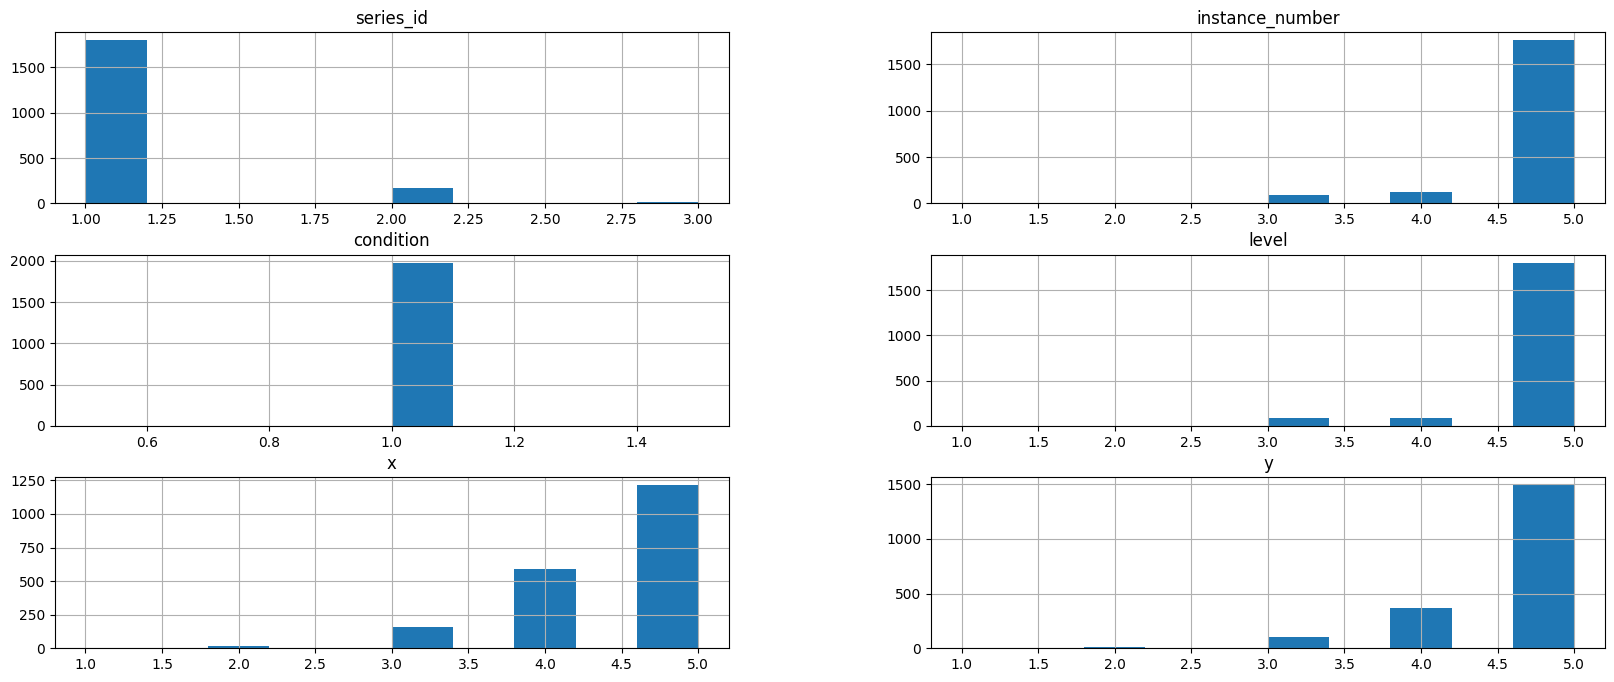

In [ ]:
df_lc_ss = df_lc[(df_lc['condition']=='Right Subarticular Stenosis')].reset_index(drop=True)
df_lc_ss.groupby('study_id').nunique().hist()

In [ ]:
df_lc_ss

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,2448190387,4,Right Subarticular Stenosis,L1/L2,145.288771,158.624642
1,4003253,2448190387,11,Right Subarticular Stenosis,L2/L3,145.900042,157.096466
2,4003253,2448190387,19,Right Subarticular Stenosis,L3/L4,142.843690,156.179561
3,4003253,2448190387,28,Right Subarticular Stenosis,L4/L5,147.428218,158.013372
4,4003253,2448190387,35,Right Subarticular Stenosis,L5/S1,145.900042,161.375358
...,...,...,...,...,...,...,...
9607,4290709089,3390218084,2,Right Subarticular Stenosis,L1/L2,307.180844,354.869960
9608,4290709089,3390218084,6,Right Subarticular Stenosis,L2/L3,301.440933,362.044847
9609,4290709089,3390218084,10,Right Subarticular Stenosis,L3/L4,302.875911,356.304937
9610,4290709089,3390218084,15,Right Subarticular Stenosis,L4/L5,305.745866,340.520184


array([[<Axes: title={'center': 'series_id'}>,
        <Axes: title={'center': 'instance_number'}>],
       [<Axes: title={'center': 'condition'}>,
        <Axes: title={'center': 'level'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

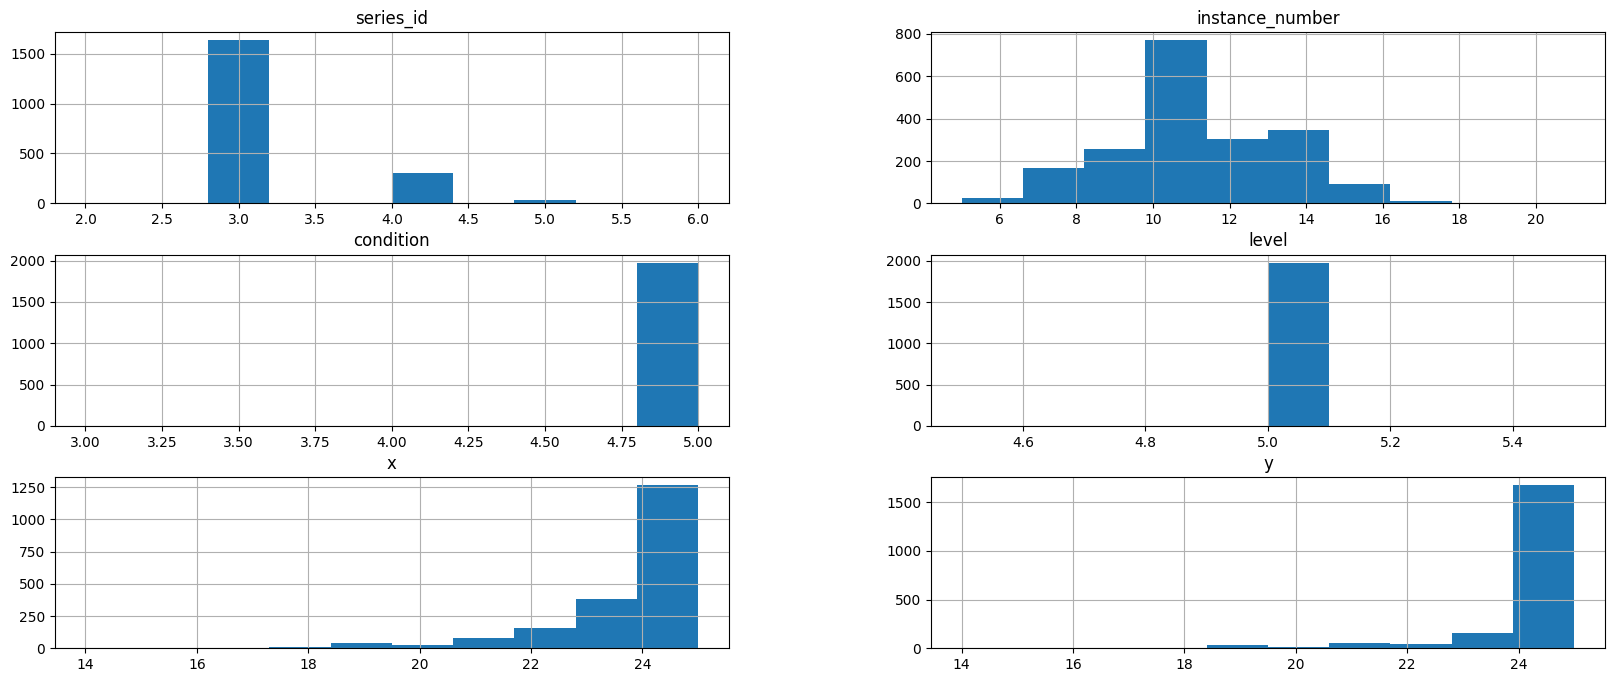

In [ ]:
df_lc.groupby('study_id').nunique().hist()

In [ ]:
df_sd

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


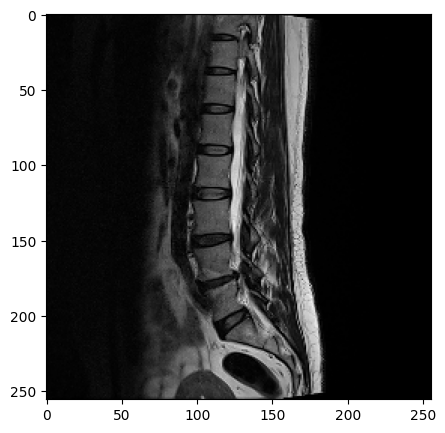

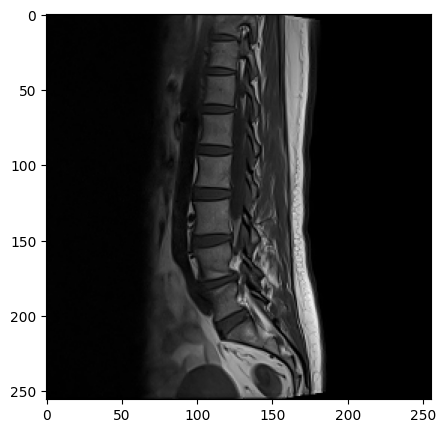

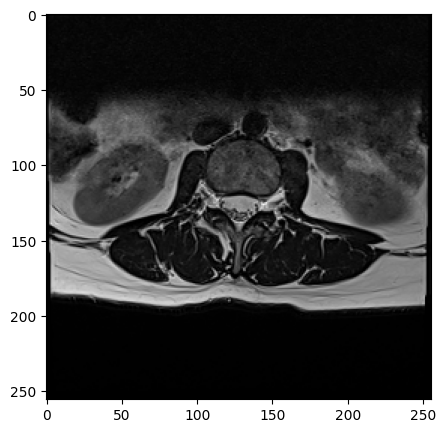

In [ ]:
# Sagital T2/STIR
study_id = 4003253
series_id = 702807833
img = cv2.imread(os.path.join(CFG.data_dir, f'{study_id}/{series_id}/10.png'))
plt.figure(figsize=(5,5))
plt.imshow(img)
# Sagital T1
study_id = 4003253
series_id = 1054713880
img = cv2.imread(os.path.join(CFG.data_dir, f'{study_id}/{series_id}/10.png'))
plt.figure(figsize=(5,5))
plt.imshow(img)

# Axial T2
study_id = 4003253
series_id = 2448190387
img = cv2.imread(os.path.join(CFG.data_dir, f'{study_id}/{series_id}/10.png'))
plt.figure(figsize=(5,5))
plt.imshow(img)

In [ ]:
df_sd.study_id.unique()

array([   4003253,    4646740,    7143189, ..., 4284048608, 4287160193,
       4290709089])

In [ ]:
def get_row_from_series_description(df_series, image_type):
    row = df_series[df_series['series_description']==image_type]
    try:
        series = row.sample(1).iloc[0]
    except:
        series = None
    return series
study_ids = []
num_imgs_sat2, num_imgs_sat1, num_imgs_axt2 = [], [], []
series_ids_sat2, series_ids_sat1, series_ids_axt2 = [], [], []
for i, row in df.iterrows():
    sid = row['study_id']
    df_series = df_sd[df_sd['study_id']==sid]
    row_sat2 = get_row_from_series_description(df_series, 'Sagittal T2/STIR')
    row_sat1 = get_row_from_series_description(df_series, 'Sagittal T1')
    row_axt2 = get_row_from_series_description(df_series, 'Axial T2')
    if row_sat2 is not None:
        filenames = glob(os.path.join(CFG.data_dir, str(sid), str(row_sat2['series_id']), '*.png'))
        num_imgs_sat2.append(len(filenames))
        series_ids_sat2.append(row_sat2['series_id'])
    else:
        num_imgs_sat2.append(0)
        series_ids_sat2.append(None)
    if row_sat1 is not None:
        filenames = glob(os.path.join(CFG.data_dir, str(sid), str(row_sat1['series_id']), '*.png'))
        num_imgs_sat1.append(len(filenames))
        series_ids_sat1.append(row_sat1['series_id'])
    else:
        num_imgs_sat1.append(0)
        series_ids_sat1.append(None)
    if row_axt2 is not None:
        filenames = glob(os.path.join(CFG.data_dir, str(sid), str(row_axt2['series_id']), '*.png'))
        num_imgs_axt2.append(len(filenames))
        series_ids_axt2.append(row_axt2['series_id'])
    else:
        num_imgs_axt2.append(0)
        series_ids_axt2.append(None)
    study_ids.append(sid)

Text(0.5, 1.0, 'Axial T2 5, 192')

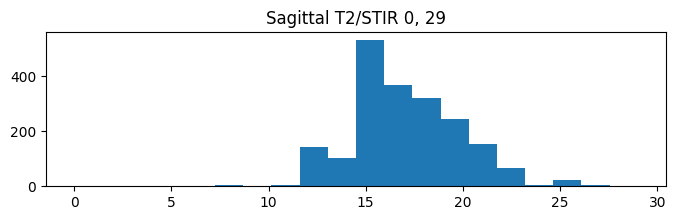

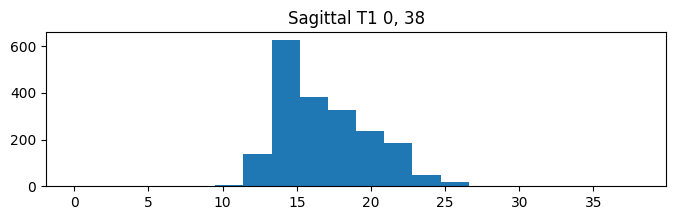

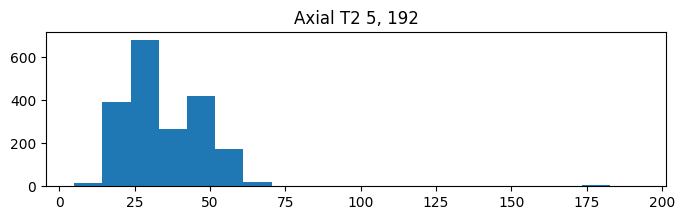

In [ ]:
plt.figure(figsize=(8,2))
plt.hist(num_imgs_sat2, bins=20)
plt.title(f'Sagittal T2/STIR {min(num_imgs_sat2)}, {max(num_imgs_sat2)}')

plt.figure(figsize=(8,2))
plt.hist(num_imgs_sat1, bins=20)
plt.title(f'Sagittal T1 {min(num_imgs_sat1)}, {max(num_imgs_sat1)}')

plt.figure(figsize=(8,2))
plt.hist(num_imgs_axt2, bins=20)
plt.title(f'Axial T2 {min(num_imgs_axt2)}, {max(num_imgs_axt2)}')

In [ ]:
df_sd[df_sd['study_id']==4290709089]

,study_id,series_id,series_description
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2
6293,4290709089,4237840455,Sagittal T1


In [ ]:
df_sd['series_description'].unique()

array(['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2'], dtype=object)

array([[<Axes: title={'center': 'series_id'}>,
        <Axes: title={'center': 'series_description'}>]], dtype=object)

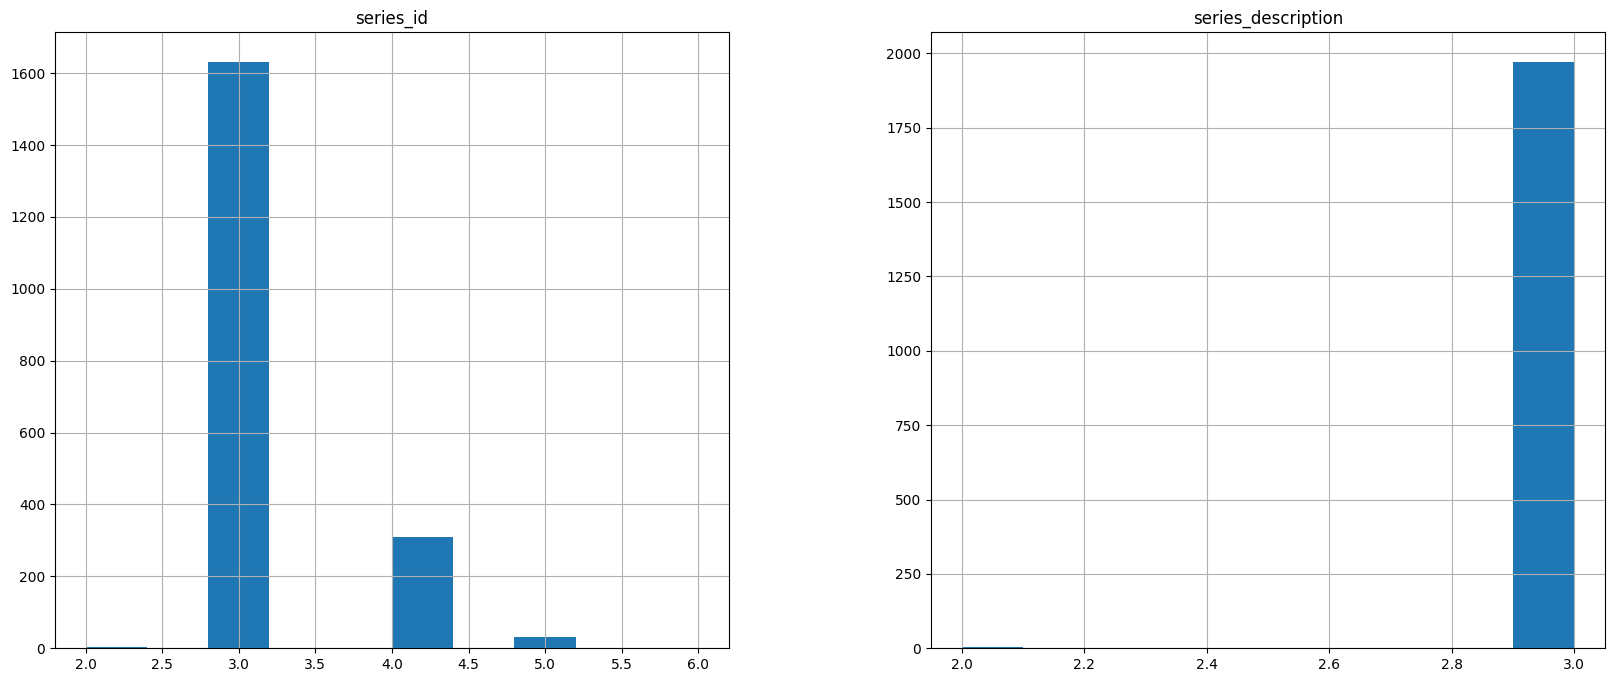

In [ ]:
df_sd.groupby('study_id').nunique().hist()

# Dataset

In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, df_lc, df_sd,
                 num_slice_sagital, num_slice_axial,
                 channel_offsets, mid_range,
                 value_neighbors, value_neighbors2,
                 mode, transform):

        self.df = df
        self.df_lc = df_lc
        self.df_sd = df_sd
        self.num_slice_sagital = num_slice_sagital
        self.num_slice_axial = num_slice_axial
        self.channel_offsets = channel_offsets
        self.mid_range = mid_range
        self.value_neighbors = value_neighbors
        self.value_neighbors2 = value_neighbors2
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        sid = row['study_id']
        df_series = self.df_sd[self.df_sd['study_id']==sid].reset_index(drop=True)
        df_lc = self.df_lc[(self.df_lc['study_id']==sid)].reset_index(drop=True)

        filenames_sat2, labels_aux_sat2 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Sagittal T2/STIR')
        filenames_sat1, labels_aux_sat1 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Sagittal T1')
        filenames_axt2, labels_aux_axt2 = self.get_files_and_auxlabel_from_series_description(df_series, df_lc, 'Axial T2')
        if labels_aux_sat2 is not None:
            labels_aux_sat2 = self.replace_vertical_neighbors(labels_aux_sat2, self.value_neighbors, self.value_neighbors2)
        if labels_aux_sat1 is not None:
            labels_aux_sat1 = self.replace_vertical_neighbors(labels_aux_sat1, self.value_neighbors, self.value_neighbors2)
        if labels_aux_axt2 is not None:
            labels_aux_axt2 = self.replace_vertical_neighbors(labels_aux_axt2, self.value_neighbors, self.value_neighbors2)
        num_files_sat2 = len(filenames_sat2)
        num_files_sat1 = len(filenames_sat1)
        num_files_axt2 = len(filenames_axt2)
        indices_sat2 = self.get_slice_indices(num_files_sat2, self.num_slice_sagital)
        indices_sat1 = self.get_slice_indices(num_files_sat1, self.num_slice_sagital)
        indices_axt2 = self.get_slice_indices(num_files_axt2, self.num_slice_axial)
        idx_plane = None
        if (self.mode == 'train')&(random.random() < CFG.p_drop_plane):
            idx_plane = random.randint(0,2)

        imgs_sat2, imgs_sat1, imgs_axt2 = [], [], []
        for idx in indices_sat2:
            img = self.load_images(idx, filenames_sat2)
            imgs_sat2.append(img)
        if (len(imgs_sat2)==0)|(idx_plane==0):
            imgs_sat2 = np.zeros([self.num_slice_sagital, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_sat2 = np.zeros([self.num_slice_sagital, 5], dtype=np.float32)
        else:
            imgs_sat2 = np.stack(imgs_sat2, 0)
            n, h, w, c = imgs_sat2.shape
            imgs_sat2 = imgs_sat2.transpose(1,2,0,3)
            imgs_sat2 = imgs_sat2.reshape(h, w, n*c)
            imgs_sat2 = self.transform(image=imgs_sat2)['image']
            imgs_sat2 = imgs_sat2.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_sat2 = imgs_sat2.transpose(2,3,0,1)
            imgs_sat2 = imgs_sat2.astype(np.float32) / 255.
            labels_aux_sat2 = labels_aux_sat2[np.clip(indices_sat2, 0, num_files_sat2-1)]
        for idx in indices_sat1:
            img = self.load_images(idx, filenames_sat1)
            imgs_sat1.append(img)
        if (len(imgs_sat1)==0)|(idx_plane==1):
            imgs_sat1 = np.zeros([self.num_slice_sagital, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_sat1 = np.zeros([self.num_slice_sagital, 5], dtype=np.float32)
        else:
            imgs_sat1 = np.stack(imgs_sat1, 0)
            n, h, w, c = imgs_sat1.shape
            imgs_sat1 = imgs_sat1.transpose(1,2,0,3)
            imgs_sat1 = imgs_sat1.reshape(h, w, n*c)
            imgs_sat1 = self.transform(image=imgs_sat1)['image']
            imgs_sat1 = imgs_sat1.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_sat1 = imgs_sat1.transpose(2,3,0,1)
            imgs_sat1 = imgs_sat1.astype(np.float32) / 255.
            labels_aux_sat1 = labels_aux_sat1[np.clip(indices_sat1, 0, num_files_sat1-1)]

        for idx in indices_axt2:
            img = self.load_images(idx, filenames_axt2)
            imgs_axt2.append(img)
        if (len(imgs_axt2)==0)|(idx_plane==2):
            imgs_axt2 = np.zeros([self.num_slice_axial, len(self.channel_offsets), CFG.image_size, CFG.image_size], dtype=np.float32)
            labels_aux_axt2 = np.zeros([self.num_slice_axial, 5], dtype=np.float32)
        else:
            imgs_axt2 = np.stack(imgs_axt2, 0)
            n, h, w, c = imgs_axt2.shape
            imgs_axt2 = imgs_axt2.transpose(1,2,0,3)
            imgs_axt2 = imgs_axt2.reshape(h, w, n*c)
            imgs_axt2 = self.transform(image=imgs_axt2)['image']
            imgs_axt2 = imgs_axt2.reshape(CFG.image_size, CFG.image_size, n, c)
            imgs_axt2 = imgs_axt2.transpose(2,3,0,1)
            imgs_axt2 = imgs_axt2.astype(np.float32) / 255.
            labels_aux_axt2 = labels_aux_axt2[np.clip(indices_axt2, 0, num_files_axt2-1)]

        if self.mode != 'test':
            if (self.mode == 'train')&(random.random() < 0.5):
                imgs_sat2 = imgs_sat2[::-1,::-1].copy()
                imgs_sat1 = imgs_sat1[::-1,::-1].copy()
                imgs_axt2 = imgs_axt2[::-1,::-1].copy()
                labels_aux_sat1 = labels_aux_sat1[::-1].copy()
                labels_aux_sat2 = labels_aux_sat2[::-1].copy()
                labels_aux_axt2 = labels_aux_axt2[::-1].copy()
            imgs_sat2 = torch.tensor(imgs_sat2).float()
            imgs_sat1 = torch.tensor(imgs_sat1).float()
            imgs_axt2 = torch.tensor(imgs_axt2).float()

            labels = torch.tensor(row[CFG.targets].values.astype(np.int64))
            # labels_l1_l2 = torch.tensor(row[CFG.targets_l1_l2].values.astype(np.int64))
            # labels_l2_l3 = torch.tensor(row[CFG.targets_l2_l3].values.astype(np.int64))
            # labels_l3_l4 = torch.tensor(row[CFG.targets_l3_l4].values.astype(np.int64))
            # labels_l4_l5 = torch.tensor(row[CFG.targets_l4_l5].values.astype(np.int64))
            # labels_l5_s1 = torch.tensor(row[CFG.targets_l5_s1].values.astype(np.int64))

            labels_aux_sat1 = torch.tensor(labels_aux_sat1)
            labels_aux_sat2 = torch.tensor(labels_aux_sat2)
            labels_aux_axt2 = torch.tensor(labels_aux_axt2)

            if self.mode == 'train' and random.random() < CFG.p_rand_order_v1:
                indices = torch.randperm(imgs_sat2.size(0))
                imgs_sat2 = imgs_sat2[indices]
                indices = torch.randperm(imgs_sat1.size(0))
                imgs_sat1 = imgs_sat1[indices]
                indices = torch.randperm(imgs_axt2.size(0))
                imgs_axt2 = imgs_axt2[indices]

            return {'image_sat1': imgs_sat1.float(),
                    'image_sat2': imgs_sat2.float(),
                    'image_axt2': imgs_axt2.float(),
                    'label': labels,
                    # 'label_l1_l2': labels_l1_l2,
                    # 'label_l2_l3': labels_l2_l3,
                    # 'label_l3_l4': labels_l3_l4,
                    # 'label_l4_l5': labels_l4_l5,
                    # 'label_l5_s1': labels_l5_s1,
                    'label_aux_sat1': labels_aux_sat1,
                    'label_aux_sat2': labels_aux_sat2,
                    'label_aux_axt2': labels_aux_axt2,
                   }
        else:
            return {'image_sat1': imgs_sat1.float(),
                    'image_sat2': imgs_sat2.float(),
                    'image_axt2': imgs_axt2.float(),
                    }

    def get_files_and_auxlabel_from_series_description(self, df_series, df_lc, image_type):
        sd2conds = {'Sagittal T2/STIR': ['Spinal Canal Stenosis'],
                   'Sagittal T1': ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing'],
                   'Axial T2': ['Left Subarticular Stenosis', 'Right Subarticular Stenosis']
                   }
        levels2idx = {'L1/L2': 0,
                      'L2/L3': 1,
                      'L3/L4': 2,
                      'L4/L5': 3,
                      'L5/S1': 4
                      }
        row_series = df_series[df_series['series_description']==image_type]
        new_row_lc = []
        conds = sd2conds[image_type]
        for cond in conds:
            new_row_lc.append(df_lc[df_lc['condition']==cond])
        new_row_lc = pd.concat(new_row_lc).reset_index(drop=True)
        try:
            if self.mode=='train':
                series = row_series.sample(1).iloc[0]
            else:
                series = row_series.iloc[0]
            sid = series['study_id']
            seid = series['series_id']
            new_row_lc = new_row_lc[new_row_lc['series_id']==seid]
            #print(os.path.join(CFG.data_dir, str(sid), str(series['series_id']), '*.png'))
            filenames = glob(os.path.join(CFG.data_dir, str(sid), str(seid), '*.png'))
            filenames = natsorted(filenames)
            labels_aux = np.zeros([len(filenames), 5], dtype=np.float32)
            for i, filename in enumerate(filenames):
                sid_, seid_ = filename.split('/')[-2:]
                seid_ = seid_.split('.')[0]
                row_lc_labeled = new_row_lc[new_row_lc['instance_number']==int(seid_)]
                if len(row_lc_labeled)!=0:
                    for j, row in row_lc_labeled.iterrows():
                        level_idx = levels2idx[row['level']]
                        labels_aux[i,level_idx] = 1.0
        except:
            filenames = []
            labels_aux = None
        return filenames, labels_aux

    def get_slice_indices(self, num_files, num_slices):
        if num_files==0:
            indices = []
        else:
            mid = int(num_files/num_slices/2)
            indices = np.round(np.linspace(mid, num_files - mid, num_slices)).astype(int)
            if self.mode=='train':
                v = min(self.mid_range, mid)
                offset = np.random.choice(np.arange(-v, v+1))
                indices += offset
        return indices

    def replace_vertical_neighbors(self, arr, replace_value=0.5, replace_value2=0.5):
        # Create a copy of the original array to avoid modifying it
        modified_arr = arr.copy()

        # Get the shape of the array
        rows, cols = arr.shape

        # Iterate over each element in the array
        for i in range(rows):
            for j in range(cols):
                if arr[i, j] == 1:
                    # Check the top neighbor
                    if i > 0 and arr[i-1, j] != 1:
                        modified_arr[i-1, j] = replace_value
                    if i > 1 and arr[i-2, j] != 1:
                        modified_arr[i-2, j] = replace_value2
                    # Check the bottom neighbor
                    if i < rows-1 and arr[i+1, j] != 1:
                        modified_arr[i+1, j] = replace_value
                    if i < rows-2 and arr[i+2, j] != 1:
                        modified_arr[i+2, j] = replace_value2

        return modified_arr

    def load_images(self, idx, filenames):
        imgs = []
        idx_max = len(filenames) - 1
        for offset in self.channel_offsets:
            idx_img = np.clip(idx + offset, 0, idx_max)
            img = cv2.imread(filenames[idx_img], cv2.IMREAD_GRAYSCALE)
            imgs.append(img)
        imgs = np.array(imgs).transpose(1,2,0)
        return imgs

In [ ]:
print(len(df))
df['fold'] = -1
df = df.fillna(-100)
kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (trn_idx, val_idx) in enumerate(kf.split(range(len(df)))):
    df.loc[val_idx, 'fold'] = fold
df = df.dropna().reset_index(drop=True)
df = df.replace(CFG.label2id)
print(len(df))
df

1975
1975


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,fold
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,5
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,2,0,0,1,1,1,0,8
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,1,1,5
1971,4283570761,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1972,4284048608,0,0,0,2,0,0,0,0,0,...,0,0,2,0,0,0,0,2,0,7
1973,4287160193,0,1,0,0,0,0,0,0,1,...,2,1,1,0,0,0,1,1,0,7


In [ ]:
rcParams['figure.figsize'] = 20,8
df_show = df.iloc[:4]
dataset_show = RSNADataset(df, df_lc, df_sd,
                           CFG.n_slice_sagital, CFG.n_slice_axial,
                           CFG.indices_ch, CFG.mid_range,
                           CFG.value_neighbors, CFG.value_neighbors2,
                           'train', transform=transforms_train
                          )
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)

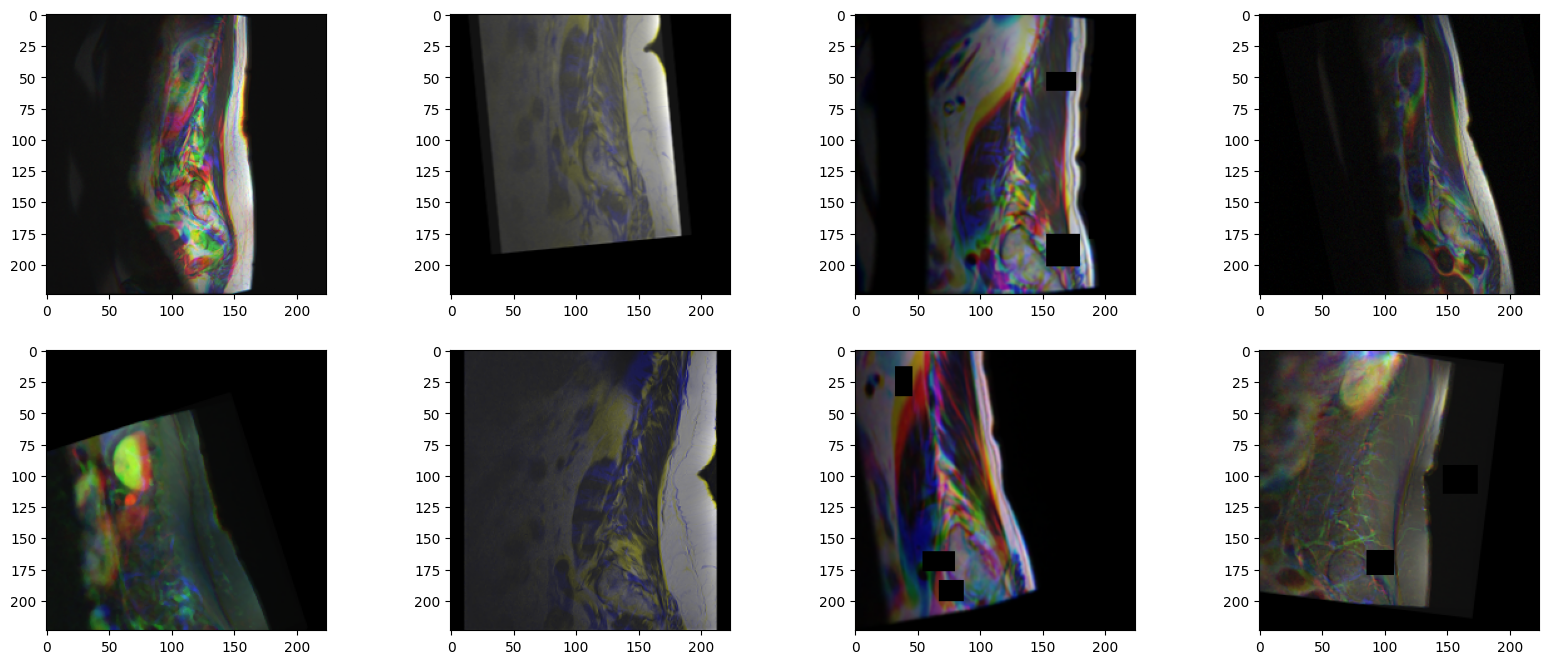

In [ ]:

f, axarr = plt.subplots(2,4)
for data in loader_show:
    imgs_sat1 = data['image_sat1']
    imgs_sat2 = data['image_sat2']
    imgs_axt2 = data['image_axt2']
    label = data['label']
    # label_l1_l2 = data['label_l1_l2']
    # label_l2_l3 = data['label_l2_l3']
    # label_l3_l4 = data['label_l3_l4']
    # label_l4_l5 = data['label_l4_l5']
    # label_l5_s1 = data['label_l5_s1']
    label_aux = data['label_aux_sat2']
    for p in range(4):
        axarr[0, p].imshow(imgs_sat1[p,1:4,0].permute(1, 2, 0))
        axarr[1, p].imshow(imgs_sat2[p,1:4,0].permute(1, 2, 0))
    break

In [ ]:
label, label_aux, imgs_axt2.shape

(tensor([[0, 0, 0, 0, 0],
         [0, 1, 0, 1, 0],
         [0, 2, 0, 0, 0],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 2, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]),
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2500, 0.2500, 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500, 0.2500, 0.2500],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.2500, 0.2500, 0.2500, 0.2500],
       

In [ ]:
df_lc[df_lc['study_id']==3867046855]

,study_id,series_id,instance_number,condition,level,x,y
43758,3867046855,35950467,8,Spinal Canal Stenosis,L1/L2,269.167975,225.054945
43759,3867046855,35950467,8,Spinal Canal Stenosis,L2/L3,251.485086,280.514914
43760,3867046855,35950467,8,Spinal Canal Stenosis,L3/L4,235.409733,329.544741
43761,3867046855,35950467,8,Spinal Canal Stenosis,L4/L5,236.953947,379.368421
43762,3867046855,35950467,8,Spinal Canal Stenosis,L5/S1,249.229167,417.333333
43763,3867046855,524901572,5,Right Neural Foraminal Narrowing,L1/L2,262.625882,215.943529
43764,3867046855,524901572,5,Right Neural Foraminal Narrowing,L2/L3,246.964706,268.348235
43765,3867046855,524901572,5,Right Neural Foraminal Narrowing,L3/L4,229.496471,320.752941
43766,3867046855,524901572,5,Right Neural Foraminal Narrowing,L4/L5,222.268235,371.952941
43767,3867046855,524901572,5,Right Neural Foraminal Narrowing,L5/S1,232.508235,415.924706


# Model

In [ ]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()

class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [ ]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.att_block = AttBlockV2(
            512, CFG.out_dim, activation="sigmoid")
#         self.head = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(CFG.drop_rate_last),
#             nn.LeakyReLU(0.1),
#             nn.Linear(256, CFG.out_dim),
#         )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, CFG.n_slice_axial, -1)
        print(feat.shape)
        feat, _ = self.lstm(feat)
        print(feat.shape)
        feat = feat.transpose(1,2)
        #feat = feat.contiguous().view(bs * CFG.n_slice_axial, -1)
        #print(feat.shape)
        #feat = self.head(feat)
        feat, _, _ = self.att_block(feat)
        print(feat.shape)
#         feat = feat.view(bs, CFG.n_slice_axial).contiguous()
#         print(feat.shape)

        return feat

class TimmModelV1(nn.Module):
    def __init__(self, model_name, in_c=30, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained,
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )

    def forward(self, x_sat1, x_sat2, x_axt2):
        x_sat1 = self.__reshape(x_sat1)
        x_sat2 = self.__reshape(x_sat2)
        x_axt2 = self.__reshape(x_axt2)
        x = torch.cat([x_sat1, x_sat2, x_axt2], dim=1)
        y = self.model(x)
        return y

    def __reshape(self, x):
        bs, n_slice, ch, h, w = x.shape
        x = x.reshape(bs, n_slice*ch, h, w)
        return x

class TimmMultiModelV1(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV1, self).__init__()

        self.encoder_sagital = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital.conv_head.out_channels
            self.encoder_sagital.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital.head.fc.in_features
            self.encoder_sagital.head.fc = nn.Identity()


        self.lstm_sagital = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)


        self.encoder_axial = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_axial.conv_head.out_channels
            self.encoder_axial.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_axial.head.fc.in_features
            self.encoder_axial.head.fc = nn.Identity()

        self.lstm_axial = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)

        self.att_block = AttBlockV2(
            512, CFG.out_dim, activation="sigmoid")
#         self.head = nn.Sequential(
#             nn.Linear(1536, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(CFG.drop_rate_last),
#             nn.LeakyReLU(0.1),
#             nn.Linear(256, out_dim),
#         )

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = x_sat1.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat1 = self.encoder_sagital(x_sat1)
        feat_sat1 = feat_sat1.view(bs, CFG.n_slice_sagital, -1)
        feat_sat1, _ = self.lstm_sagital(feat_sat1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = x_sat2.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat2 = self.encoder_sagital(x_sat2)
        feat_sat2 = feat_sat2.view(bs, CFG.n_slice_sagital, -1)
        feat_sat2, _ = self.lstm_sagital(feat_sat2)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = x_axt2.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_axt2 = self.encoder_sagital(x_axt2)
        feat_axt2 = feat_axt2.view(bs, CFG.n_slice_axial, -1)
        feat_axt2, _ = self.lstm_axial(feat_axt2)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = feat.transpose(1,2)

        #feat = self.head(feat)
        feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat

class TimmMultiModelV2(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV2, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)

        self.att_block = AttBlockV2(
            512, CFG.out_dim, activation="sigmoid")
#         self.head = nn.Sequential(
#             nn.Linear(1536, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(CFG.drop_rate_last),
#             nn.LeakyReLU(0.1),
#             nn.Linear(256, out_dim),
#         )

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = x_sat1.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat1 = self.encoder(x_sat1)
        feat_sat1 = feat_sat1.view(bs, CFG.n_slice_sagital, -1)
        feat_sat1, _ = self.lstm(feat_sat1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = x_sat2.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat2 = self.encoder(x_sat2)
        feat_sat2 = feat_sat2.view(bs, CFG.n_slice_sagital, -1)
        feat_sat2, _ = self.lstm(feat_sat2)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = x_axt2.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_axt2 = self.encoder(x_axt2)
        feat_axt2 = feat_axt2.view(bs, CFG.n_slice_axial, -1)
        feat_axt2, _ = self.lstm(feat_axt2)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = feat.transpose(1,2)

        #feat = self.head(feat)
        feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat

class TimmMultiModelV3(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV3, self).__init__()

        self.encoder_sagital = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital.conv_head.out_channels
            self.encoder_sagital.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital.head.fc.in_features
            self.encoder_sagital.head.fc = nn.Identity()

        self.encoder_axial = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_axial.conv_head.out_channels
            self.encoder_axial.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_axial.head.fc.in_features
            self.encoder_axial.head.fc = nn.Identity()

        self.att_block = AttBlockV2(
            hdim, CFG.out_dim, activation="sigmoid")
#         self.head = nn.Sequential(
#             nn.Linear(1536, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(CFG.drop_rate_last),
#             nn.LeakyReLU(0.1),
#             nn.Linear(256, out_dim),
#         )

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = x_sat1.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat1 = self.encoder_sagital(x_sat1)
        feat_sat1 = feat_sat1.view(bs, CFG.n_slice_sagital, -1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = x_sat2.view(bs * CFG.n_slice_sagital, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_sat2 = self.encoder_sagital(x_sat2)
        feat_sat2 = feat_sat2.view(bs, CFG.n_slice_sagital, -1)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = x_axt2.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat_axt2 = self.encoder_sagital(x_axt2)
        feat_axt2 = feat_axt2.view(bs, CFG.n_slice_axial, -1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = feat.transpose(1,2)

        #feat = self.head(feat)
        feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat

class TimmMultiModelV4(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV4, self).__init__()

        self.encoder_sagital = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_sagital,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital.conv_head.out_channels
            self.encoder_sagital.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital.head.fc.in_features
            self.encoder_sagital.head.fc = nn.Identity()

        self.encoder_axial = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_axial,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_axial.conv_head.out_channels
            self.encoder_axial.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_axial.head.fc.in_features
            self.encoder_axial.head.fc = nn.Identity()

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head = nn.Sequential(
            # nn.Linear(hdim*3, 256),
            # nn.BatchNorm1d(256),
            nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(hdim*3, CFG.out_dim),
        )

    def __reshape(self, x):
        bs, n_slice, ch, h, w = x.shape
        x = x.reshape(bs, n_slice*ch, h, w)
        return x

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = self.__reshape(x_sat1)
        feat_sat1 = self.encoder_sagital(x_sat1)
        feat_sat1 = feat_sat1.view(bs, -1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = self.__reshape(x_sat2)
        feat_sat2 = self.encoder_sagital(x_sat2)
        feat_sat2 = feat_sat2.view(bs, -1)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = self.__reshape(x_axt2)
        feat_axt2 = self.encoder_axial(x_axt2)
        feat_axt2 = feat_axt2.view(bs,  -1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = self.head(feat)
        return feat

class TimmMultiModelV5(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmMultiModelV5, self).__init__()

        self.encoder_sagital1 = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_sagital,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital1.conv_head.out_channels
            self.encoder_sagital1.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital1.head.fc.in_features
            self.encoder_sagital1.head.fc = nn.Identity()

        self.encoder_sagital2 = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_sagital,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_sagital2.conv_head.out_channels
            self.encoder_sagital2.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_sagital2.head.fc.in_features
            self.encoder_sagital2.head.fc = nn.Identity()

        self.encoder_axial = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_axial,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder_axial.conv_head.out_channels
            self.encoder_axial.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder_axial.head.fc.in_features
            self.encoder_axial.head.fc = nn.Identity()

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head = nn.Sequential(
            # nn.Linear(hdim*3, 256),
            # nn.BatchNorm1d(256),
            #nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(hdim*3, CFG.out_dim),
        )

    def __reshape(self, x):
        bs, n_slice, ch, h, w = x.shape
        x = x.reshape(bs, n_slice*ch, h, w)
        return x

    def forward(self, x_sat1, x_sat2, x_axt2):  # (bs, nslice, ch, sz, sz)
        bs = x_sat1.shape[0]
        x_sat1 = self.__reshape(x_sat1)
        feat_sat1 = self.encoder_sagital1(x_sat1)
        feat_sat1 = feat_sat1.view(bs, -1)
        #feat_sat1 = feat_sat1.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_sat2.shape[0]
        x_sat2 = self.__reshape(x_sat2)
        feat_sat2 = self.encoder_sagital2(x_sat2)
        feat_sat2 = feat_sat2.view(bs, -1)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        bs = x_axt2.shape[0]
        x_axt2 = self.__reshape(x_axt2)
        feat_axt2 = self.encoder_axial(x_axt2)
        feat_axt2 = feat_axt2.view(bs,  -1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = torch.cat([feat_sat1, feat_sat2, feat_axt2], dim=1)
        feat = self.head(feat)
        return feat

In [ ]:
class TimmSinglePlaneModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmSinglePlaneModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.n_slice_axial,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.head = nn.Sequential(
            # nn.Linear(hdim*3, 256),
            # nn.BatchNorm1d(256),
            #nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(hdim, CFG.out_dim),
        )

    def __reshape(self, x):
        bs, n_slice, ch, h, w = x.shape
        x = x.reshape(bs, n_slice*ch, h, w)
        return x

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = self.__reshape(x)
        feat = self.encoder(x)
        feat = feat.view(bs, -1)
        #feat_sat2 = feat_sat2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = self.head(feat)
        return feat

class TimmSingleModelV4(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmSingleModelV4, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        #self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.rnn = nn.GRU(input_size=hdim, hidden_size=128, num_layers=1, bidirectional=True)

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, CFG.out_dim),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * CFG.n_slice_axial, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, CFG.n_slice_axial, -1)
        feat, _ = self.rnn(feat)
        feat_slice = feat.mean(2)
        feat = feat.mean(1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat, feat_slice

class TimmSingleModelV5(nn.Module):
    def __init__(self, backbone, in_chans, out_chans, pretrained=False):
        super(TimmSingleModelV5, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_chans,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        #self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.rnn = nn.GRU(input_size=hdim, hidden_size=128, num_layers=1, bidirectional=True)

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head_binary = nn.Linear(256, 5)
        self.head = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, out_chans),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs, n_slice = x.shape[:2]
        x = x.view(bs * n_slice, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice, -1)
        feat, _ = self.rnn(feat)
        feat = feat.view(bs*n_slice, -1)
        feat_binary = self.head_binary(feat)
        feat_binary = feat_binary.view(bs, n_slice, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice, -1)
        #feat = feat.mean(1)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        #feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat, feat_binary

class TimmSingleModelV6(nn.Module):
    def __init__(self, backbone, in_chans, out_chans, pretrained=False):
        super(TimmSingleModelV6, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_chans,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        #self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.rnn = nn.GRU(input_size=hdim, hidden_size=128, num_layers=1, bidirectional=True)

        # self.att_block = AttBlockV2(
        #     hdim, CFG.out_dim, activation="sigmoid")
        self.head_binary = nn.Linear(256, 5)
        self.head_slice = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, out_chans),
        )
        self.head = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.Dropout(CFG.drop_rate_last),
            # nn.LeakyReLU(0.1),
            nn.Linear(256, out_chans),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs, n_slice = x.shape[:2]
        x = x.view(bs * n_slice, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice, -1)
        feat, _ = self.rnn(feat)
        feat = feat.view(bs*n_slice, -1)
        feat_binary = self.head_binary(feat)
        feat_binary = feat_binary.view(bs, n_slice, -1)
        feat_slice = self.head_slice(feat)
        feat_slice = feat_slice.view(bs, n_slice, -1)
        feat = feat.view(bs, n_slice, -1)
        feat = feat.mean(1)
        feat = self.head(feat)
        #feat_axt2 = feat_axt2.contiguous().view(bs * CFG.n_slice_sagital, -1)

        #feat = self.head(feat)
        #feat = feat.transpose(1,2)
        #feat, _, _ = self.att_block(feat)
        #feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat, feat_slice, feat_binary

In [ ]:
m = TimmSingleModelV6(CFG.backbone, in_chans=CFG.in_chans, out_chans=CFG.out_dim)
out = m(imgs_sat2,
  )
out[0].shape, out[1].shape, out[2].shape

(torch.Size([8, 15]), torch.Size([8, 10, 15]), torch.Size([8, 10, 5]))

In [ ]:
imgs_sat2.shape

torch.Size([8, 10, 5, 224, 224])

# Loss & Metric

In [ ]:
def criterion(logits, targets, activated=False):
    bce = nn.BCEWithLogitsLoss(reduction='none')
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 2.
    norm = torch.ones(logits.view(-1).shape[0]).to(device)
    norm[targets.view(-1) > 0] *= 2
    return losses.sum() / norm.sum()

def criterion_multi(logits, targets, weights):
    ce = nn.CrossEntropyLoss(weight=weights.to(device))
    losses = 0
    for col in range(CFG.num_targets):
        pred = logits[:,col*3:col*3+3]
        gt = targets[:,col]
        losses = losses + ce(pred, gt) / CFG.num_targets
    return losses

def criterion_aux(logits, targets):
    bce = nn.BCEWithLogitsLoss(reduction='none')
    losses = bce(logits, targets)
    return losses.mean()

def criterion_multi_aux(logits, logits_aux,
                        targets_l1_l2, targets_l2_l3,
                        targets_l3_l4, targets_l4_l5,
                        targets_l5_s1, targets_aux,
                        weights):
    bce = nn.BCEWithLogitsLoss(reduction='none')
    ce = nn.CrossEntropyLoss(reduction='none', weight=weights)
    losses_aux = bce(logits_aux, targets_aux)
    losses = 0

    for col in range(len(CFG.targets_l1_l2)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l1_l2[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,0:1].view(-1)/ len(CFG.targets_l1_l2)
        losses = losses + loss.mean()

    for col in range(len(CFG.targets_l2_l3)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l2_l3[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,1:2].view(-1)/ len(CFG.targets_l2_l3)
        losses = losses + loss.mean()

    for col in range(len(CFG.targets_l3_l4)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l3_l4[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,2:3].view(-1)/ len(CFG.targets_l3_l4)
        losses = losses + loss.mean()

    for col in range(len(CFG.targets_l4_l5)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l4_l5[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,3:4].view(-1)/ len(CFG.targets_l4_l5)
        losses = losses + loss.mean()

    for col in range(len(CFG.targets_l5_s1)):
        pred = logits[:,:,col*3:col*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets_l5_s1[:,col]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        loss = losses_main * targets_aux[:,:,4:5].view(-1)/ len(CFG.targets_l5_s1)
        losses = losses + loss.mean()

    return losses, losses_aux.mean()

def criterion_multi_aux_v2(logits, logits_aux,
                        targets, targets_aux,
                        weights):
    bce = nn.BCEWithLogitsLoss(reduction='none')
    ce = nn.CrossEntropyLoss(reduction='none', weight=weights)
    losses_aux = bce(logits_aux, targets_aux)
    losses = 0

    for i, colname in enumerate(CFG.targets):
        pred = logits[:,:,i*3:i*3+3]
        bs, n_slice = pred.shape[:2]
        pred = pred.view(bs*n_slice, -1)
        gt = targets[:,i]
        gt = gt.repeat_interleave(n_slice)
        losses_main = ce(pred, gt)
        if '_l1_l2' in colname:
            loss = losses_main * targets_aux[:,:,0:1].view(-1)/ len(CFG.targets)
        elif '_l2_l3' in colname:
            loss = losses_main * targets_aux[:,:,1:2].view(-1)/ len(CFG.targets)
        elif '_l3_l4' in colname:
            loss = losses_main * targets_aux[:,:,2:3].view(-1)/ len(CFG.targets)
        elif '_l4_l5' in colname:
            loss = losses_main * targets_aux[:,:,3:4].view(-1)/ len(CFG.targets)
        elif '_l5_s1' in colname:
            loss = losses_main * targets_aux[:,:,4:5].view(-1)/ len(CFG.targets)
        else:
            assert False
        losses = losses + loss.mean()

    return losses, losses_aux.mean()

In [ ]:
criterion_multi_aux_v2(out[1].to('cpu'), out[2].to('cpu'),
                    label.to('cpu'), label_aux.to('cpu'),
                    weights = torch.tensor([1.0, 2.0, 4.0]).to('cpu')
                    )

(tensor(0.1062, grad_fn=<AddBackward0>),
 tensor(0.6884, grad_fn=<MeanBackward0>))

# Train & Valid func

In [ ]:
def mixup(input_sat1, input_sat2, input_axt2,
          truth, truth_aux, clip=[0, 1]):
    indices = torch.randperm(input_sat1.size(0))
    shuffled_input_sat1 = input_sat1[indices]
    shuffled_input_sat2 = input_sat2[indices]
    shuffled_input_axt2 = input_axt2[indices]
    shuffled_labels = truth[indices]
    shuffled_labels_aux = truth_aux[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input_sat1 = input_sat1 * lam + shuffled_input_sat1 * (1 - lam)
    input_sat2 = input_sat2 * lam + shuffled_input_sat2 * (1 - lam)
    input_axt2 = input_axt2 * lam + shuffled_input_axt2 * (1 - lam)
    return input_sat1, input_sat2, input_axt2,\
           truth, shuffled_labels, truth_aux, shuffled_labels_aux, lam


def train_func(model, loader_train, optimizer, epoch, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    weights = torch.tensor([1.0, 2.0, 4.0]).to(device)
    for data in bar:
        optimizer.zero_grad()
        images_sat1 = data['image_sat1']
        images_sat2 = data['image_sat2']
        images_axt2 = data['image_axt2']
        targets = data['label']
        targets_aux = data['label_aux_sat2']
        images_sat1 = images_sat1.cuda()
        images_sat2 = images_sat2.cuda()
        images_axt2 = images_axt2.cuda()
        targets = targets.cuda()
        targets_aux = targets_aux.cuda()

        do_mixup = False
        if (random.random() < CFG.p_mixup)&(CFG.n_epochs_mixup>epoch):
            do_mixup = True
            images_sat1, images_sat2, images_axt2, targets, targets_mix, targets_aux, targets_aux_mix, lam = \
            mixup(images_sat1, images_sat2, images_axt2, targets, targets_aux)

        with amp.autocast():
            #logits = model(images_sat1, images_sat2, images_axt2)
            logits, logits_slice, logits_aux = model(images_sat2)
            loss_main_1 = criterion_multi(logits, targets, weights=weights)
            loss_main_2, loss_aux = criterion_multi_aux_v2(logits_slice, logits_aux,
                                                      targets, targets_aux,
                                                      weights=weights
                                                     )
            loss = loss_main_1 * CFG.loss_weights[0] + loss_main_2 * CFG.loss_weights[1] + loss_aux * CFG.loss_weights[2]
            if do_mixup:
                loss11_main_1 = criterion_multi(logits, targets_mix, weights=weights)
                loss11_main_2, loss11_aux = criterion_multi_aux_v2(logits_slice, logits_aux,
                                                              targets_mix, targets_aux_mix,
                                                              weights=weights
                                                              )
                loss11 = loss11_main_1 * CFG.loss_weights[0] + loss11_main_2 * CFG.loss_weights[1] + loss11_aux * CFG.loss_weights[2]
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    gts_aux = []
    outputs = []
    outputs_slice = []
    outputs_aux = []
    bar = tqdm(loader_valid)
    weights = torch.tensor([1.0, 2.0, 4.0]).to(device)
    with torch.no_grad():
        for data in bar:
            images_sat1 = data['image_sat1']
            images_sat2 = data['image_sat2']
            images_axt2 = data['image_axt2']
            targets = data['label']
            targets_aux = data['label_aux_sat2']
            images_sat1 = images_sat1.cuda()
            images_sat2 = images_sat2.cuda()
            images_axt2 = images_axt2.cuda()
            targets = targets.cuda()
            targets_aux = targets_aux.cuda()

            #logits = model(images_sat1, images_sat2, images_axt2)
            logits, logits_slice, logits_aux = model(images_sat2)
            loss_main_1 = criterion_multi(logits, targets, weights=weights)
            loss_main_2, loss_aux = criterion_multi_aux_v2(logits_slice, logits_aux,
                                                      targets, targets_aux,
                                                      weights=weights
                                                     )
            loss = loss_main_1 * CFG.loss_weights[0] + loss_main_2 * CFG.loss_weights[1] + loss_aux * CFG.loss_weights[2]

            gts.append(targets)
            gts_aux.append(targets_aux)
            outputs.append(logits)
            outputs_slice.append(logits_slice)
            outputs_aux.append(logits_aux)
            valid_loss.append(loss.item())

            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    outputs = torch.cat(outputs)
    outputs_slice = torch.cat(outputs_slice)
    outputs_aux = torch.cat(outputs_aux)
    gts = torch.cat(gts)
    gts_aux = torch.cat(gts_aux)
    valid_loss_main_1 = criterion_multi(outputs, gts, weights=weights)
    valid_loss_main_2, valid_loss_aux = criterion_multi_aux_v2(outputs_slice, outputs_aux,
                                                          gts, gts_aux,
                                                          weights=weights
                                                          )
    valid_loss = valid_loss_main_1 * CFG.loss_weights[0] + valid_loss_main_2 * CFG.loss_weights[1] + valid_loss_aux * CFG.loss_weights[2]
    # outputs_final = []
    # for i in range(5):
    #     output_level = outputs * outputs_aux.sigmoid()[...,i:i+1]# * (outputs_aux[...,i:i+1]>thr)
    #     outputs_final.append(output_level)
    # outputs_final = torch.cat(outputs_final, dim=2)
    # outputs_final = outputs_final.sum(1)
    # for col in range(len(CFG.targets)):
    #     pred_final = F.softmax(outputs_final[:,col*3:col*3+3], dim=1)
    #     outputs_final[:,col*3:col*3+3] = pred_final
    #score = criterion_multi(outputs_final, gts, weights)

    return valid_loss_main_1.item(), valid_loss.item()#, score.item()


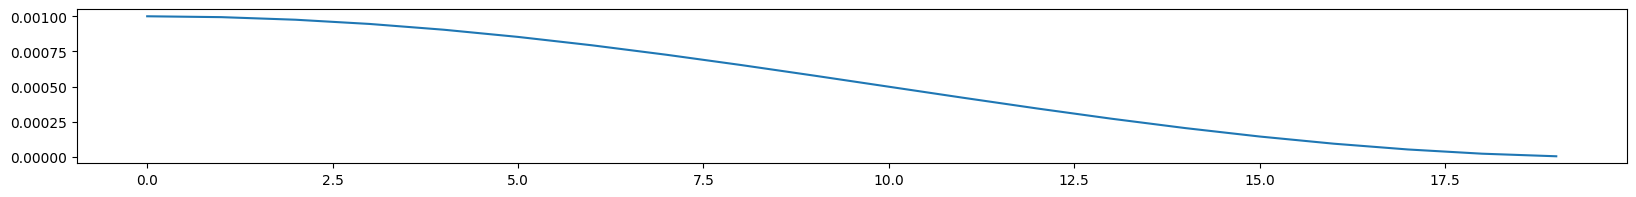

In [ ]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=1e-3)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, T_mult=1, eta_min=CFG.eta_min)

lrs = []
for epoch in range(1, CFG.n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [ ]:
def run(fold):

    log_file = os.path.join(CFG.log_dir, f'{CFG.kernel_type}.txt')
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = RSNADataset(train_, df_lc, df_sd,
                                CFG.n_slice_sagital, CFG.n_slice_axial,
                                CFG.indices_ch, CFG.mid_range,
                                CFG.value_neighbors, CFG.value_neighbors2,
                                'train', transform=transforms_train
                               )
    dataset_valid = RSNADataset(valid_, df_lc, df_sd,
                                CFG.n_slice_sagital, CFG.n_slice_axial,
                                CFG.indices_ch, CFG.mid_range,
                                CFG.value_neighbors, CFG.value_neighbors2,
                                'train', transform=transforms_valid
                               )
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model = TimmSingleModelV6(CFG.backbone, in_chans=CFG.in_chans, out_chans=CFG.out_dim, pretrained=True)
    #model = TimmModelV1(CFG.backbone, in_c=int(CFG.n_slice_axial+CFG.n_slice_sagital*2), n_classes=CFG.out_dim, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.init_lr)
    scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None

    metric_best = np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, CFG.n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, epoch, scaler)
        valid_loss_main, valid_loss = valid_func(model, loader_valid)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid loss main: {valid_loss_main:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()
    return metric_best


In [ ]:
RUN_TRAIN = True
if RUN_TRAIN:
    folds = [0, 1, 2, 3, 4]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

<ipython-input-46-7e30efd71751>:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1777 198
Fri Sep  6 04:34:03 2024 Epoch: 1


  0%|          | 0/222 [00:00<?, ?it/s]<ipython-input-44-249e550a8e5e>:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
smth:0.1174: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 04:38:41 2024 Fold 0, Epoch 1, lr: 0.0005000, train loss: 0.15967, valid loss: 0.11749, valid loss main: 1.24605, metric: 0.117493.
metric_best (inf --> 0.117493). Saving model ...
Fri Sep  6 04:38:42 2024 Epoch: 2


smth:0.1163: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Fri Sep  6 04:43:20 2024 Fold 0, Epoch 2, lr: 0.0004969, train loss: 0.13251, valid loss: 0.11653, valid loss main: 1.23280, metric: 0.116527.
metric_best (0.117493 --> 0.116527). Saving model ...
Fri Sep  6 04:43:21 2024 Epoch: 3


smth:0.1146: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Fri Sep  6 04:47:56 2024 Fold 0, Epoch 3, lr: 0.0004878, train loss: 0.12927, valid loss: 0.11471, valid loss main: 1.23717, metric: 0.114715.
metric_best (0.116527 --> 0.114715). Saving model ...
Fri Sep  6 04:47:57 2024 Epoch: 4


smth:0.1141: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Fri Sep  6 04:52:29 2024 Fold 0, Epoch 4, lr: 0.0004728, train loss: 0.12794, valid loss: 0.11416, valid loss main: 1.23093, metric: 0.114164.
metric_best (0.114715 --> 0.114164). Saving model ...
Fri Sep  6 04:52:30 2024 Epoch: 5


smth:0.1134: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 04:56:57 2024 Fold 0, Epoch 5, lr: 0.0004523, train loss: 0.12651, valid loss: 0.11362, valid loss main: 1.23395, metric: 0.113615.
metric_best (0.114164 --> 0.113615). Saving model ...
Fri Sep  6 04:56:57 2024 Epoch: 6


smth:0.1079: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Fri Sep  6 05:01:24 2024 Fold 0, Epoch 6, lr: 0.0004268, train loss: 0.12633, valid loss: 0.10808, valid loss main: 1.26034, metric: 0.108078.
metric_best (0.113615 --> 0.108078). Saving model ...
Fri Sep  6 05:01:24 2024 Epoch: 7


smth:0.1099: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 05:05:54 2024 Fold 0, Epoch 7, lr: 0.0003970, train loss: 0.12530, valid loss: 0.11005, valid loss main: 1.23818, metric: 0.110051.
Fri Sep  6 05:05:54 2024 Epoch: 8


smth:0.1078: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 05:10:24 2024 Fold 0, Epoch 8, lr: 0.0003635, train loss: 0.12438, valid loss: 0.10789, valid loss main: 1.25432, metric: 0.107890.
metric_best (0.108078 --> 0.107890). Saving model ...
Fri Sep  6 05:10:25 2024 Epoch: 9


smth:0.1069: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Fri Sep  6 05:14:54 2024 Fold 0, Epoch 9, lr: 0.0003273, train loss: 0.12287, valid loss: 0.10700, valid loss main: 1.23639, metric: 0.107004.
metric_best (0.107890 --> 0.107004). Saving model ...
Fri Sep  6 05:14:54 2024 Epoch: 10


smth:0.1075: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Fri Sep  6 05:19:25 2024 Fold 0, Epoch 10, lr: 0.0002892, train loss: 0.12197, valid loss: 0.10757, valid loss main: 1.24944, metric: 0.107566.
Fri Sep  6 05:19:25 2024 Epoch: 11


smth:0.1039: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 05:23:57 2024 Fold 0, Epoch 11, lr: 0.0002501, train loss: 0.12074, valid loss: 0.10404, valid loss main: 1.23968, metric: 0.104037.
metric_best (0.107004 --> 0.104037). Saving model ...
Fri Sep  6 05:23:57 2024 Epoch: 12


smth:0.1060: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


Fri Sep  6 05:28:37 2024 Fold 0, Epoch 12, lr: 0.0002109, train loss: 0.11991, valid loss: 0.10617, valid loss main: 1.24456, metric: 0.106172.
Fri Sep  6 05:28:37 2024 Epoch: 13


smth:0.1050: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 05:33:24 2024 Fold 0, Epoch 13, lr: 0.0001728, train loss: 0.12093, valid loss: 0.10516, valid loss main: 1.24726, metric: 0.105157.
Fri Sep  6 05:33:24 2024 Epoch: 14


smth:0.1040: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Fri Sep  6 05:37:58 2024 Fold 0, Epoch 14, lr: 0.0001366, train loss: 0.11967, valid loss: 0.10415, valid loss main: 1.24945, metric: 0.104145.
Fri Sep  6 05:37:58 2024 Epoch: 15


smth:0.1051: 100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


Fri Sep  6 05:42:29 2024 Fold 0, Epoch 15, lr: 0.0001031, train loss: 0.11899, valid loss: 0.10517, valid loss main: 1.25022, metric: 0.105174.
Fri Sep  6 05:42:29 2024 Epoch: 16


smth:0.1043: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 05:46:58 2024 Fold 0, Epoch 16, lr: 0.0000733, train loss: 0.11896, valid loss: 0.10446, valid loss main: 1.24863, metric: 0.104458.
Fri Sep  6 05:46:58 2024 Epoch: 17


smth:0.1034: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 05:51:28 2024 Fold 0, Epoch 17, lr: 0.0000478, train loss: 0.11840, valid loss: 0.10355, valid loss main: 1.24984, metric: 0.103548.
metric_best (0.104037 --> 0.103548). Saving model ...
Fri Sep  6 05:51:28 2024 Epoch: 18


smth:0.1037: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Fri Sep  6 05:56:00 2024 Fold 0, Epoch 18, lr: 0.0000273, train loss: 0.09462, valid loss: 0.10387, valid loss main: 1.25622, metric: 0.103873.
Fri Sep  6 05:56:00 2024 Epoch: 19


smth:0.1050: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 06:00:36 2024 Fold 0, Epoch 19, lr: 0.0000123, train loss: 0.09427, valid loss: 0.10512, valid loss main: 1.25925, metric: 0.105118.
Fri Sep  6 06:00:36 2024 Epoch: 20


smth:0.1048: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Fri Sep  6 06:05:12 2024 Fold 0, Epoch 20, lr: 0.0000032, train loss: 0.09445, valid loss: 0.10490, valid loss main: 1.26048, metric: 0.104903.
1777 198
Fri Sep  6 06:05:13 2024 Epoch: 1


smth:0.1175: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 06:09:44 2024 Fold 1, Epoch 1, lr: 0.0005000, train loss: 0.15940, valid loss: 0.11781, valid loss main: 1.19647, metric: 0.117814.
metric_best (inf --> 0.117814). Saving model ...
Fri Sep  6 06:09:45 2024 Epoch: 2


smth:0.1283: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 06:14:13 2024 Fold 1, Epoch 2, lr: 0.0004969, train loss: 0.13278, valid loss: 0.12849, valid loss main: 1.18266, metric: 0.128490.
Fri Sep  6 06:14:13 2024 Epoch: 3


smth:0.1101: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Fri Sep  6 06:18:45 2024 Fold 1, Epoch 3, lr: 0.0004878, train loss: 0.13072, valid loss: 0.11048, valid loss main: 1.18063, metric: 0.110477.
metric_best (0.117814 --> 0.110477). Saving model ...
Fri Sep  6 06:18:45 2024 Epoch: 4


smth:0.1138: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 06:23:14 2024 Fold 1, Epoch 4, lr: 0.0004728, train loss: 0.12732, valid loss: 0.11407, valid loss main: 1.19673, metric: 0.114074.
Fri Sep  6 06:23:15 2024 Epoch: 5


smth:0.1121: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 06:27:48 2024 Fold 1, Epoch 5, lr: 0.0004523, train loss: 0.12704, valid loss: 0.11233, valid loss main: 1.19128, metric: 0.112326.
Fri Sep  6 06:27:48 2024 Epoch: 6


smth:0.1028: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 06:32:25 2024 Fold 1, Epoch 6, lr: 0.0004268, train loss: 0.12664, valid loss: 0.10316, valid loss main: 1.18387, metric: 0.103163.
metric_best (0.110477 --> 0.103163). Saving model ...
Fri Sep  6 06:32:25 2024 Epoch: 7


smth:0.1013: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Fri Sep  6 06:36:54 2024 Fold 1, Epoch 7, lr: 0.0003970, train loss: 0.12534, valid loss: 0.10147, valid loss main: 1.18662, metric: 0.101467.
metric_best (0.103163 --> 0.101467). Saving model ...
Fri Sep  6 06:36:54 2024 Epoch: 8


smth:0.1024: 100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


Fri Sep  6 06:41:27 2024 Fold 1, Epoch 8, lr: 0.0003635, train loss: 0.12396, valid loss: 0.10267, valid loss main: 1.18608, metric: 0.102667.
Fri Sep  6 06:41:27 2024 Epoch: 9


smth:0.1001: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Fri Sep  6 06:45:54 2024 Fold 1, Epoch 9, lr: 0.0003273, train loss: 0.12289, valid loss: 0.10044, valid loss main: 1.19434, metric: 0.100442.
metric_best (0.101467 --> 0.100442). Saving model ...
Fri Sep  6 06:45:55 2024 Epoch: 10


smth:0.1020: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Fri Sep  6 06:50:25 2024 Fold 1, Epoch 10, lr: 0.0002892, train loss: 0.12123, valid loss: 0.10227, valid loss main: 1.20066, metric: 0.102273.
Fri Sep  6 06:50:25 2024 Epoch: 11


smth:0.0988: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Fri Sep  6 06:54:55 2024 Fold 1, Epoch 11, lr: 0.0002501, train loss: 0.12391, valid loss: 0.09908, valid loss main: 1.19813, metric: 0.099083.
metric_best (0.100442 --> 0.099083). Saving model ...
Fri Sep  6 06:54:55 2024 Epoch: 12


smth:0.0995: 100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


Fri Sep  6 06:59:27 2024 Fold 1, Epoch 12, lr: 0.0002109, train loss: 0.12075, valid loss: 0.09993, valid loss main: 1.19473, metric: 0.099930.
Fri Sep  6 06:59:28 2024 Epoch: 13


smth:0.1021: 100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


Fri Sep  6 07:03:56 2024 Fold 1, Epoch 13, lr: 0.0001728, train loss: 0.11992, valid loss: 0.10232, valid loss main: 1.19496, metric: 0.102323.
Fri Sep  6 07:03:56 2024 Epoch: 14


smth:0.1054: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 07:08:38 2024 Fold 1, Epoch 14, lr: 0.0001366, train loss: 0.12004, valid loss: 0.10569, valid loss main: 1.19499, metric: 0.105686.
Fri Sep  6 07:08:39 2024 Epoch: 15


smth:0.1039: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 07:13:16 2024 Fold 1, Epoch 15, lr: 0.0001031, train loss: 0.11900, valid loss: 0.10387, valid loss main: 1.19375, metric: 0.103868.
Fri Sep  6 07:13:16 2024 Epoch: 16


smth:0.1010: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 07:17:54 2024 Fold 1, Epoch 16, lr: 0.0000733, train loss: 0.11919, valid loss: 0.10136, valid loss main: 1.19829, metric: 0.101362.
Fri Sep  6 07:17:55 2024 Epoch: 17


smth:0.1022: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 07:22:30 2024 Fold 1, Epoch 17, lr: 0.0000478, train loss: 0.11898, valid loss: 0.10240, valid loss main: 1.19770, metric: 0.102402.
Fri Sep  6 07:22:31 2024 Epoch: 18


smth:0.1012: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 07:27:04 2024 Fold 1, Epoch 18, lr: 0.0000273, train loss: 0.09526, valid loss: 0.10149, valid loss main: 1.19959, metric: 0.101487.
Fri Sep  6 07:27:05 2024 Epoch: 19


smth:0.1014: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 07:31:41 2024 Fold 1, Epoch 19, lr: 0.0000123, train loss: 0.09373, valid loss: 0.10142, valid loss main: 1.20019, metric: 0.101417.
Fri Sep  6 07:31:41 2024 Epoch: 20


smth:0.1017: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Fri Sep  6 07:36:14 2024 Fold 1, Epoch 20, lr: 0.0000032, train loss: 0.09402, valid loss: 0.10208, valid loss main: 1.20080, metric: 0.102083.
1777 198
Fri Sep  6 07:36:14 2024 Epoch: 1


smth:0.1195: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Fri Sep  6 07:40:44 2024 Fold 2, Epoch 1, lr: 0.0005000, train loss: 0.15903, valid loss: 0.11988, valid loss main: 1.31711, metric: 0.119884.
metric_best (inf --> 0.119884). Saving model ...
Fri Sep  6 07:40:45 2024 Epoch: 2


smth:0.1083: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Fri Sep  6 07:45:12 2024 Fold 2, Epoch 2, lr: 0.0004969, train loss: 0.13188, valid loss: 0.10859, valid loss main: 1.32875, metric: 0.108594.
metric_best (0.119884 --> 0.108594). Saving model ...
Fri Sep  6 07:45:12 2024 Epoch: 3


smth:0.1196: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Fri Sep  6 07:49:47 2024 Fold 2, Epoch 3, lr: 0.0004878, train loss: 0.13009, valid loss: 0.11980, valid loss main: 1.33382, metric: 0.119804.
Fri Sep  6 07:49:47 2024 Epoch: 4


smth:0.1076: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Fri Sep  6 07:54:21 2024 Fold 2, Epoch 4, lr: 0.0004728, train loss: 0.12838, valid loss: 0.10782, valid loss main: 1.33417, metric: 0.107818.
metric_best (0.108594 --> 0.107818). Saving model ...
Fri Sep  6 07:54:21 2024 Epoch: 5


smth:0.1047: 100%|██████████| 25/25 [00:23<00:00,  1.09it/s]


Fri Sep  6 07:58:50 2024 Fold 2, Epoch 5, lr: 0.0004523, train loss: 0.12724, valid loss: 0.10495, valid loss main: 1.30438, metric: 0.104948.
metric_best (0.107818 --> 0.104948). Saving model ...
Fri Sep  6 07:58:51 2024 Epoch: 6


smth:0.1053: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 08:03:23 2024 Fold 2, Epoch 6, lr: 0.0004268, train loss: 0.12701, valid loss: 0.10557, valid loss main: 1.29137, metric: 0.105573.
Fri Sep  6 08:03:23 2024 Epoch: 7


smth:0.1027: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 08:07:55 2024 Fold 2, Epoch 7, lr: 0.0003970, train loss: 0.12585, valid loss: 0.10303, valid loss main: 1.31245, metric: 0.103030.
metric_best (0.104948 --> 0.103030). Saving model ...
Fri Sep  6 08:07:55 2024 Epoch: 8


smth:0.1053: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 08:12:24 2024 Fold 2, Epoch 8, lr: 0.0003635, train loss: 0.12460, valid loss: 0.10535, valid loss main: 1.29431, metric: 0.105351.
Fri Sep  6 08:12:24 2024 Epoch: 9


smth:0.1018: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 08:16:52 2024 Fold 2, Epoch 9, lr: 0.0003273, train loss: 0.12475, valid loss: 0.10188, valid loss main: 1.28673, metric: 0.101885.
metric_best (0.103030 --> 0.101885). Saving model ...
Fri Sep  6 08:16:52 2024 Epoch: 10


smth:0.1072: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Fri Sep  6 08:21:22 2024 Fold 2, Epoch 10, lr: 0.0002892, train loss: 0.12172, valid loss: 0.10728, valid loss main: 1.31149, metric: 0.107283.
Fri Sep  6 08:21:22 2024 Epoch: 11


smth:0.1039: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 08:25:56 2024 Fold 2, Epoch 11, lr: 0.0002501, train loss: 0.12216, valid loss: 0.10408, valid loss main: 1.29610, metric: 0.104077.
Fri Sep  6 08:25:57 2024 Epoch: 12


smth:0.1000: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 08:30:33 2024 Fold 2, Epoch 12, lr: 0.0002109, train loss: 0.12111, valid loss: 0.10027, valid loss main: 1.30362, metric: 0.100271.
metric_best (0.101885 --> 0.100271). Saving model ...
Fri Sep  6 08:30:33 2024 Epoch: 13


smth:0.1039: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 08:35:08 2024 Fold 2, Epoch 13, lr: 0.0001728, train loss: 0.12047, valid loss: 0.10397, valid loss main: 1.30444, metric: 0.103971.
Fri Sep  6 08:35:08 2024 Epoch: 14


smth:0.1015: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Fri Sep  6 08:39:47 2024 Fold 2, Epoch 14, lr: 0.0001366, train loss: 0.12022, valid loss: 0.10178, valid loss main: 1.30725, metric: 0.101779.
Fri Sep  6 08:39:47 2024 Epoch: 15


smth:0.1031: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 08:44:22 2024 Fold 2, Epoch 15, lr: 0.0001031, train loss: 0.11918, valid loss: 0.10313, valid loss main: 1.30730, metric: 0.103125.
Fri Sep  6 08:44:23 2024 Epoch: 16


smth:0.1020: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Fri Sep  6 08:48:52 2024 Fold 2, Epoch 16, lr: 0.0000733, train loss: 0.11980, valid loss: 0.10203, valid loss main: 1.30442, metric: 0.102027.
Fri Sep  6 08:48:52 2024 Epoch: 17


smth:0.0995: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Fri Sep  6 08:53:23 2024 Fold 2, Epoch 17, lr: 0.0000478, train loss: 0.11872, valid loss: 0.09969, valid loss main: 1.30177, metric: 0.099689.
metric_best (0.100271 --> 0.099689). Saving model ...
Fri Sep  6 08:53:24 2024 Epoch: 18


smth:0.0995: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 08:57:52 2024 Fold 2, Epoch 18, lr: 0.0000273, train loss: 0.09540, valid loss: 0.09968, valid loss main: 1.30177, metric: 0.099685.
metric_best (0.099689 --> 0.099685). Saving model ...
Fri Sep  6 08:57:52 2024 Epoch: 19


smth:0.0989: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 09:02:24 2024 Fold 2, Epoch 19, lr: 0.0000123, train loss: 0.09491, valid loss: 0.09919, valid loss main: 1.30497, metric: 0.099188.
metric_best (0.099685 --> 0.099188). Saving model ...
Fri Sep  6 09:02:24 2024 Epoch: 20


smth:0.1008: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Fri Sep  6 09:06:53 2024 Fold 2, Epoch 20, lr: 0.0000032, train loss: 0.09460, valid loss: 0.10103, valid loss main: 1.30553, metric: 0.101027.
1777 198
Fri Sep  6 09:06:53 2024 Epoch: 1


smth:0.1161: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 09:11:27 2024 Fold 3, Epoch 1, lr: 0.0005000, train loss: 0.15932, valid loss: 0.11603, valid loss main: 1.22275, metric: 0.116031.
metric_best (inf --> 0.116031). Saving model ...
Fri Sep  6 09:11:27 2024 Epoch: 2


smth:0.1129: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Fri Sep  6 09:15:59 2024 Fold 3, Epoch 2, lr: 0.0004969, train loss: 0.13006, valid loss: 0.11282, valid loss main: 1.22151, metric: 0.112824.
metric_best (0.116031 --> 0.112824). Saving model ...
Fri Sep  6 09:16:00 2024 Epoch: 3


smth:0.1141: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 09:20:34 2024 Fold 3, Epoch 3, lr: 0.0004878, train loss: 0.12904, valid loss: 0.11389, valid loss main: 1.20678, metric: 0.113890.
Fri Sep  6 09:20:34 2024 Epoch: 4


smth:0.1080: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


Fri Sep  6 09:25:05 2024 Fold 3, Epoch 4, lr: 0.0004728, train loss: 0.12822, valid loss: 0.10776, valid loss main: 1.20985, metric: 0.107764.
metric_best (0.112824 --> 0.107764). Saving model ...
Fri Sep  6 09:25:06 2024 Epoch: 5


smth:0.1083: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Fri Sep  6 09:29:39 2024 Fold 3, Epoch 5, lr: 0.0004523, train loss: 0.12461, valid loss: 0.10797, valid loss main: 1.21759, metric: 0.107966.
Fri Sep  6 09:29:39 2024 Epoch: 6


smth:0.1063: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Fri Sep  6 09:34:12 2024 Fold 3, Epoch 6, lr: 0.0004268, train loss: 0.12520, valid loss: 0.10612, valid loss main: 1.21470, metric: 0.106119.
metric_best (0.107764 --> 0.106119). Saving model ...
Fri Sep  6 09:34:12 2024 Epoch: 7


smth:0.1060: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 09:38:50 2024 Fold 3, Epoch 7, lr: 0.0003970, train loss: 0.12372, valid loss: 0.10581, valid loss main: 1.21676, metric: 0.105810.
metric_best (0.106119 --> 0.105810). Saving model ...
Fri Sep  6 09:38:50 2024 Epoch: 8


smth:0.1050: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Fri Sep  6 09:43:21 2024 Fold 3, Epoch 8, lr: 0.0003635, train loss: 0.12318, valid loss: 0.10483, valid loss main: 1.21725, metric: 0.104832.
metric_best (0.105810 --> 0.104832). Saving model ...
Fri Sep  6 09:43:22 2024 Epoch: 9


smth:0.1056: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Fri Sep  6 09:47:59 2024 Fold 3, Epoch 9, lr: 0.0003273, train loss: 0.12162, valid loss: 0.10558, valid loss main: 1.21562, metric: 0.105581.
Fri Sep  6 09:48:00 2024 Epoch: 10


smth:0.1069: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


Fri Sep  6 09:52:35 2024 Fold 3, Epoch 10, lr: 0.0002892, train loss: 0.12217, valid loss: 0.10674, valid loss main: 1.21304, metric: 0.106739.
Fri Sep  6 09:52:35 2024 Epoch: 11


smth:0.1069: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 09:57:09 2024 Fold 3, Epoch 11, lr: 0.0002501, train loss: 0.12047, valid loss: 0.10666, valid loss main: 1.21587, metric: 0.106658.
Fri Sep  6 09:57:09 2024 Epoch: 12


smth:0.1030: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 10:01:48 2024 Fold 3, Epoch 12, lr: 0.0002109, train loss: 0.12087, valid loss: 0.10300, valid loss main: 1.20749, metric: 0.102996.
metric_best (0.104832 --> 0.102996). Saving model ...
Fri Sep  6 10:01:49 2024 Epoch: 13


smth:0.1049: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 10:06:25 2024 Fold 3, Epoch 13, lr: 0.0001728, train loss: 0.11927, valid loss: 0.10469, valid loss main: 1.20495, metric: 0.104695.
Fri Sep  6 10:06:25 2024 Epoch: 14


smth:0.1022: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 10:11:02 2024 Fold 3, Epoch 14, lr: 0.0001366, train loss: 0.11874, valid loss: 0.10226, valid loss main: 1.20504, metric: 0.102256.
metric_best (0.102996 --> 0.102256). Saving model ...
Fri Sep  6 10:11:02 2024 Epoch: 15


smth:0.1036: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 10:15:37 2024 Fold 3, Epoch 15, lr: 0.0001031, train loss: 0.11976, valid loss: 0.10357, valid loss main: 1.20741, metric: 0.103575.
Fri Sep  6 10:15:38 2024 Epoch: 16


smth:0.1033: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 10:20:08 2024 Fold 3, Epoch 16, lr: 0.0000733, train loss: 0.11898, valid loss: 0.10344, valid loss main: 1.20433, metric: 0.103436.
Fri Sep  6 10:20:09 2024 Epoch: 17


smth:0.1057: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Fri Sep  6 10:24:38 2024 Fold 3, Epoch 17, lr: 0.0000478, train loss: 0.11762, valid loss: 0.10559, valid loss main: 1.20663, metric: 0.105588.
Fri Sep  6 10:24:38 2024 Epoch: 18


smth:0.1039: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 10:29:13 2024 Fold 3, Epoch 18, lr: 0.0000273, train loss: 0.09431, valid loss: 0.10379, valid loss main: 1.20323, metric: 0.103787.
Fri Sep  6 10:29:13 2024 Epoch: 19


smth:0.1070: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 10:33:50 2024 Fold 3, Epoch 19, lr: 0.0000123, train loss: 0.09201, valid loss: 0.10698, valid loss main: 1.20102, metric: 0.106977.
Fri Sep  6 10:33:51 2024 Epoch: 20


smth:0.1062: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Fri Sep  6 10:38:26 2024 Fold 3, Epoch 20, lr: 0.0000032, train loss: 0.09265, valid loss: 0.10602, valid loss main: 1.20208, metric: 0.106020.
1777 198
Fri Sep  6 10:38:27 2024 Epoch: 1


smth:0.1184: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Fri Sep  6 10:43:00 2024 Fold 4, Epoch 1, lr: 0.0005000, train loss: 0.15786, valid loss: 0.11827, valid loss main: 1.22892, metric: 0.118266.
metric_best (inf --> 0.118266). Saving model ...
Fri Sep  6 10:43:00 2024 Epoch: 2


smth:0.1210: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 10:47:36 2024 Fold 4, Epoch 2, lr: 0.0004969, train loss: 0.13152, valid loss: 0.12095, valid loss main: 1.20562, metric: 0.120955.
Fri Sep  6 10:47:36 2024 Epoch: 3


smth:0.1087: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Fri Sep  6 10:52:15 2024 Fold 4, Epoch 3, lr: 0.0004878, train loss: 0.12870, valid loss: 0.10860, valid loss main: 1.21663, metric: 0.108602.
metric_best (0.118266 --> 0.108602). Saving model ...
Fri Sep  6 10:52:16 2024 Epoch: 4


smth:0.1113: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Fri Sep  6 10:56:49 2024 Fold 4, Epoch 4, lr: 0.0004728, train loss: 0.12795, valid loss: 0.11124, valid loss main: 1.20299, metric: 0.111238.
Fri Sep  6 10:56:49 2024 Epoch: 5


smth:0.1101: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Fri Sep  6 11:01:21 2024 Fold 4, Epoch 5, lr: 0.0004523, train loss: 0.12657, valid loss: 0.11002, valid loss main: 1.21117, metric: 0.110020.
Fri Sep  6 11:01:21 2024 Epoch: 6


smth:0.1069: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Fri Sep  6 11:06:00 2024 Fold 4, Epoch 6, lr: 0.0004268, train loss: 0.12643, valid loss: 0.10683, valid loss main: 1.19820, metric: 0.106827.
metric_best (0.108602 --> 0.106827). Saving model ...
Fri Sep  6 11:06:00 2024 Epoch: 7


smth:0.1112: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 11:10:35 2024 Fold 4, Epoch 7, lr: 0.0003970, train loss: 0.12426, valid loss: 0.11113, valid loss main: 1.19676, metric: 0.111129.
Fri Sep  6 11:10:35 2024 Epoch: 8


smth:0.1081: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 11:15:07 2024 Fold 4, Epoch 8, lr: 0.0003635, train loss: 0.12198, valid loss: 0.10803, valid loss main: 1.20369, metric: 0.108032.
Fri Sep  6 11:15:07 2024 Epoch: 9


smth:0.1068: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 11:19:38 2024 Fold 4, Epoch 9, lr: 0.0003273, train loss: 0.12437, valid loss: 0.10675, valid loss main: 1.20467, metric: 0.106749.
metric_best (0.106827 --> 0.106749). Saving model ...
Fri Sep  6 11:19:38 2024 Epoch: 10


smth:0.1070: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


Fri Sep  6 11:24:08 2024 Fold 4, Epoch 10, lr: 0.0002892, train loss: 0.12227, valid loss: 0.10696, valid loss main: 1.19896, metric: 0.106957.
Fri Sep  6 11:24:09 2024 Epoch: 11


smth:0.1051: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Fri Sep  6 11:28:41 2024 Fold 4, Epoch 11, lr: 0.0002501, train loss: 0.12173, valid loss: 0.10506, valid loss main: 1.18879, metric: 0.105060.
metric_best (0.106749 --> 0.105060). Saving model ...
Fri Sep  6 11:28:42 2024 Epoch: 12


smth:0.1038: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 11:33:13 2024 Fold 4, Epoch 12, lr: 0.0002109, train loss: 0.12169, valid loss: 0.10380, valid loss main: 1.20477, metric: 0.103797.
metric_best (0.105060 --> 0.103797). Saving model ...
Fri Sep  6 11:33:13 2024 Epoch: 13


smth:0.1062: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 11:37:42 2024 Fold 4, Epoch 13, lr: 0.0001728, train loss: 0.12005, valid loss: 0.10607, valid loss main: 1.20419, metric: 0.106068.
Fri Sep  6 11:37:42 2024 Epoch: 14


smth:0.1035: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Fri Sep  6 11:42:10 2024 Fold 4, Epoch 14, lr: 0.0001366, train loss: 0.12016, valid loss: 0.10327, valid loss main: 1.20854, metric: 0.103273.
metric_best (0.103797 --> 0.103273). Saving model ...
Fri Sep  6 11:42:10 2024 Epoch: 15


smth:0.1042: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Fri Sep  6 11:46:41 2024 Fold 4, Epoch 15, lr: 0.0001031, train loss: 0.11934, valid loss: 0.10416, valid loss main: 1.20838, metric: 0.104157.
Fri Sep  6 11:46:41 2024 Epoch: 16


smth:0.1039: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 11:51:09 2024 Fold 4, Epoch 16, lr: 0.0000733, train loss: 0.11769, valid loss: 0.10383, valid loss main: 1.20506, metric: 0.103826.
Fri Sep  6 11:51:09 2024 Epoch: 17


smth:0.1025: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Fri Sep  6 11:55:41 2024 Fold 4, Epoch 17, lr: 0.0000478, train loss: 0.11607, valid loss: 0.10239, valid loss main: 1.20576, metric: 0.102393.
metric_best (0.103273 --> 0.102393). Saving model ...
Fri Sep  6 11:55:42 2024 Epoch: 18


smth:0.1022: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 12:00:17 2024 Fold 4, Epoch 18, lr: 0.0000273, train loss: 0.09461, valid loss: 0.10203, valid loss main: 1.20869, metric: 0.102029.
metric_best (0.102393 --> 0.102029). Saving model ...
Fri Sep  6 12:00:17 2024 Epoch: 19


smth:0.1049: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Fri Sep  6 12:04:49 2024 Fold 4, Epoch 19, lr: 0.0000123, train loss: 0.09391, valid loss: 0.10486, valid loss main: 1.21140, metric: 0.104859.
Fri Sep  6 12:04:49 2024 Epoch: 20


smth:0.1060: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Fri Sep  6 12:09:20 2024 Fold 4, Epoch 20, lr: 0.0000032, train loss: 0.09453, valid loss: 0.10590, valid loss main: 1.20878, metric: 0.105896.


In [ ]:
if RUN_TRAIN:
    print(best_scores)
    np.mean(best_scores)

[0.1035478338599205, 0.0990828275680542, 0.09918829798698425, 0.10225646197795868, 0.10202893614768982]


In [ ]:
def inference_fn(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    gts_aux = []
    outputs = []
    outputs_slice = []
    outputs_aux = []
    bar = tqdm(loader_valid)
    weights = torch.tensor([1.0, 2.0, 4.0]).to(device)
    with torch.no_grad():
        for data in bar:
            images_sat1 = data['image_sat1']
            images_sat2 = data['image_sat2']
            images_axt2 = data['image_axt2']
            targets = data['label']
            targets_aux = data['label_aux_sat2']
            images_sat1 = images_sat1.cuda()
            images_sat2 = images_sat2.cuda()
            images_axt2 = images_axt2.cuda()
            targets = targets.cuda()
            targets_aux = targets_aux.cuda()

            #logits = model(images_sat1, images_sat2, images_axt2)
            logits, logits_slice, logits_aux = model(images_sat2) #torch.Size([8, 20, 6]), torch.Size([8, 20, 5])

            gts.append(targets)
            gts_aux.append(targets_aux)
            outputs.append(logits)
            outputs_slice.append(logits_slice)
            outputs_aux.append(logits_aux)

    outputs = torch.cat(outputs)
    # for col in range(len(CFG.targets_l1_l2)):
    #     pred = outputs[:,:,col*3:col*3+3]
    #     outputs[:,:,col*3:col*3+3] = F.softmax(pred, dim=2)
    outputs_slice = torch.cat(outputs_slice)
    outputs_aux = torch.cat(outputs_aux).sigmoid()
    gts = torch.cat(gts)
    gts_aux = torch.cat(gts_aux)
    return outputs, outputs_slice, outputs_aux, gts, gts_aux

In [ ]:
outputs, outputs_slice, outputs_aux, gts, gts_aux = [], [], [], [], []
for fold in [0, 1, 2, 3, 4]:
    valid_ = df[df['fold'] == fold].reset_index(drop=True)

    dataset_valid = RSNADataset(valid_, df_lc, df_sd,
                                CFG.n_slice_sagital, CFG.n_slice_axial,
                                CFG.indices_ch, CFG.mid_range,
                                CFG.value_neighbors, CFG.value_neighbors2,
                                'valid', transform=transforms_valid
                                )
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model = TimmSingleModelV6(CFG.backbone, in_chans=CFG.in_chans, out_chans=CFG.out_dim, pretrained=True)
    model.load_state_dict(torch.load(os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')))
    #model = TimmModelV1(CFG.backbone, in_c=int(CFG.n_slice_axial+CFG.n_slice_sagital*2), n_classes=CFG.out_dim, pretrained=True)
    model = model.to(device)

    outputs_, outputs_slice_, outputs_aux_, gts_, gts_aux_ = inference_fn(model, loader_valid)
    outputs.append(outputs_)
    outputs_slice.append(outputs_slice_)
    outputs_aux.append(outputs_aux_)
    gts.append(gts_)
    gts_aux.append(gts_aux_)
outputs = torch.cat(outputs)
outputs_slice = torch.cat(outputs_slice)
outputs_aux = torch.cat(outputs_aux)
gts = torch.cat(gts)
gts_aux = torch.cat(gts_aux)



<ipython-input-50-81e40e35b28f>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}

In [ ]:
outputs.shape, outputs_aux.shape, gts.shape, gts_aux.shape

(torch.Size([990, 15]),
 torch.Size([990, 10, 5]),
 torch.Size([990, 5]),
 torch.Size([990, 10, 5]))

In [ ]:
outputs[0]

tensor([-0.4584, -0.0628,  0.5568, -0.5845,  0.4320,  0.0020, -0.4927, -0.1682,
         0.0557,  0.0807,  0.3582, -1.0251,  0.6978, -0.0034,  0.3837],
       device='cuda:0')

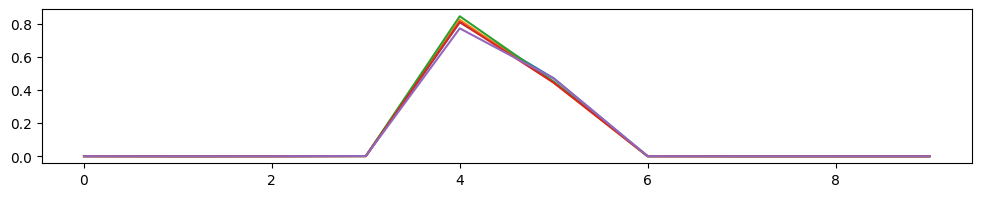

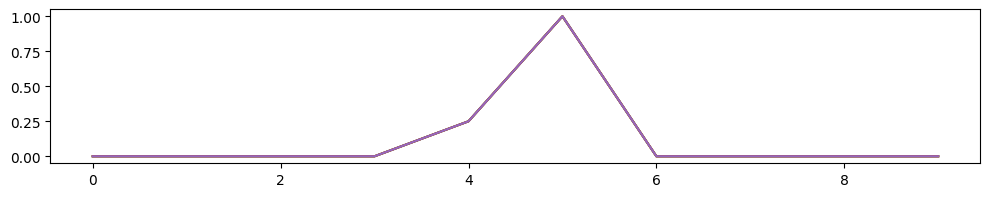

In [ ]:
idx = 10
plt.figure(figsize=(12,2))
pred_aux = outputs_aux[idx].cpu().detach().numpy()
plt.plot(pred_aux)
plt.figure(figsize=(12,2))
gt_aux = gts_aux[idx].cpu().detach().numpy()
plt.plot(gt_aux)

In [ ]:
thr = 0.0
t = 0.15
outputs_slice_final = torch.zeros([outputs_slice.shape[0], outputs_slice.shape[2]], dtype=torch.float32)
for i, colname in enumerate(CFG.targets):
    if '_l1_l2' in colname:
        outputs_stack = outputs_slice[...,i*3:(i+1)*3] * outputs_aux[...,0:1] * (outputs_aux[...,0:1]>thr)
        outputs_slice_final[:,i*3:(i+1)*3] = outputs_stack.mean(1)/t
    elif '_l2_l3' in colname:
        outputs_stack = outputs_slice[...,i*3:(i+1)*3] * outputs_aux[...,1:2] * (outputs_aux[...,1:2]>thr)
        outputs_slice_final[:,i*3:(i+1)*3] = outputs_stack.mean(1)/t
    elif '_l3_l4' in colname:
        outputs_stack = outputs_slice[...,i*3:(i+1)*3] * outputs_aux[...,2:3] * (outputs_aux[...,2:3]>thr)
        outputs_slice_final[:,i*3:(i+1)*3] = outputs_stack.mean(1)/t
    elif '_l4_l5' in colname:
        outputs_stack = outputs_slice[...,i*3:(i+1)*3] * outputs_aux[...,3:4] * (outputs_aux[...,3:4]>thr)
        outputs_slice_final[:,i*3:(i+1)*3] = outputs_stack.mean(1)/t
    elif '_l5_s1' in colname:
        outputs_stack = outputs_slice[...,i*3:(i+1)*3] * outputs_aux[...,4:5] * (outputs_aux[...,4:5]>thr)
        outputs_slice_final[:,i*3:(i+1)*3] = outputs_stack.mean(1)/t
    else:
        assert False


# outputs_final = outputs_final.sum(1)
# for col in range(len(CFG.targets)):
#     pred_final = F.softmax(outputs_final[:,col*3:col*3+3], dim=1)
#     outputs_final[:,col*3:col*3+3] = pred_final

In [ ]:
outputs_slice_final[idx], gts[idx], len(outputs_slice_final[idx]), len(gts[idx])


(tensor([ 5.1354, -2.3156, -4.5569,  4.6749, -2.6959, -3.9557,  4.9912, -1.5500,
         -3.2825,  4.0794, -1.8314, -2.5857,  5.0160, -2.0660, -3.7008]),
 tensor([0, 0, 0, 0, 0], device='cuda:0'),
 15,
 5)

In [ ]:
weights = torch.tensor([1.0, 2.0, 4.0]).to(device)
print(criterion_multi(outputs_slice_final.to(device), gts, weights))
print(criterion_multi(outputs.to(device), gts, weights))

tensor(0.3720, device='cuda:0')
tensor(0.3839, device='cuda:0')


In [ ]:
out_weights = [0.3, 0.7]
outputs_mix = outputs * out_weights[0] + outputs_slice_final.to(device) * out_weights[1]
print(criterion_multi(outputs_mix.to(device), gts, weights))

tensor(0.3689, device='cuda:0')


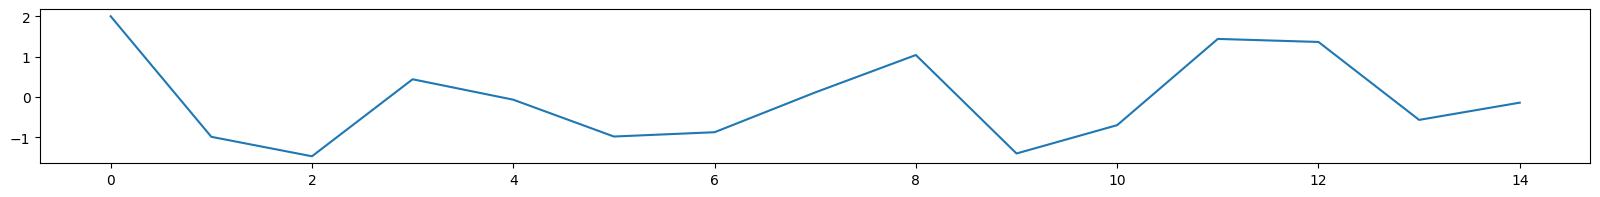

In [ ]:
plt.plot(outputs_slice_final[1].cpu().detach().numpy())